In [1]:
import os
import zipfile
import shutil
import keras
import math
import functools
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import seaborn as sns
from keras import layers
import imgaug.augmenters as iaa
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.metrics import classification_report, f1_score, roc_curve, auc
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3, DenseNet121, Xception, EfficientNetB2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, save_img

In [2]:
print(tf.test.is_built_with_cuda())
print(tf.config.list_physical_devices('GPU'))

True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
image_dataset_folder = 'Berrijam Datasets/'
dataset_file = input("Enter the dataset filename: ")
if dataset_file == "Needs Respray":
    folder = zipfile.ZipFile(image_dataset_folder + "Data - Needs Respray - 2024-03-26.zip", "r")
    folder.extractall()
    folder.close()
    dataset_dir = "Data - Needs Respray - 2024-03-26"
elif dataset_file == "Is Epic Intro":
    folder = zipfile.ZipFile(image_dataset_folder + "Data - Is Epic Intro 2024-03-25.zip", "r")
    folder.extractall()
    folder.close()
    dataset_dir = "Data - Is Epic Intro 2024-03-25"
elif data_file == "Is GenAI":
    folder = zipfile.ZipFile(image_dataset_folder + "Data - Is GenAI - 2024-03-25.zip", "r")
    folder.extractall()
    folder.close()
    dataset_dir = "Data - Is GenAI - 2024-03-25"

Enter the dataset filename:  Needs Respray


EDA

In [4]:
for filename in os.listdir(dataset_dir):
  if filename.endswith('g'):
    img_path = os.path.join(dataset_dir, filename)
    img = Image.open(img_path)
    img_array = np.array(img)
    print(f"Image: {filename}")
    print(f"Min pixel value: {np.min(img_array)}")
    print(f"Max pixel value: {np.max(img_array)}\n")

Image: paver weeds - 03.png
Min pixel value: 0
Max pixel value: 255

Image: paver weeds - 09.png
Min pixel value: 0
Max pixel value: 255

Image: paver weeds - 17.png
Min pixel value: 0
Max pixel value: 255

Image: paver weeds - 25.png
Min pixel value: 0
Max pixel value: 255

Image: paver weeds - 32.png
Min pixel value: 0
Max pixel value: 250

Image: paver weeds - 36.png
Min pixel value: 0
Max pixel value: 250

Image: paver weeds - 43.png
Min pixel value: 0
Max pixel value: 250

Image: paver weeds - 47.png
Min pixel value: 0
Max pixel value: 250

Image: paver weeds - 59.png
Min pixel value: 0
Max pixel value: 250

Image: paver weeds - 63.png
Min pixel value: 0
Max pixel value: 249

Image: paver weeds - 77.png
Min pixel value: 0
Max pixel value: 249

Image: paver weeds - 85.png
Min pixel value: 0
Max pixel value: 250



The image have pixel values ranging from 0 to 249 or 0 to 250 instead of the expected range of 0 to 255. To ensure that all images have pixel values in the range of 0 to 255, we have to normalize the images to rescale the pixel values accordingly.

In [5]:
for filename in os.listdir(dataset_dir):
    if filename.endswith('g'):
        img_path = os.path.join(dataset_dir, filename)
        img = Image.open(img_path)
        img_array = np.array(img)
        img_array = (img_array / np.max(img_array)) * 255
        img_array = img_array.astype(np.uint8)
        
        print(f"Image: {filename}")
        
        print(f"Min pixel value: {np.min(img_array)}")
        print(f"Max pixel value: {np.max(img_array)}\n")

        img = Image.fromarray(img_array)
        img.save(img_path)
        print(f"{filename} has been updated and saved.\n")

Image: paver weeds - 03.png
Min pixel value: 0
Max pixel value: 255

paver weeds - 03.png has been updated and saved.

Image: paver weeds - 09.png
Min pixel value: 0
Max pixel value: 255

paver weeds - 09.png has been updated and saved.

Image: paver weeds - 17.png
Min pixel value: 0
Max pixel value: 255

paver weeds - 17.png has been updated and saved.

Image: paver weeds - 25.png
Min pixel value: 0
Max pixel value: 255

paver weeds - 25.png has been updated and saved.

Image: paver weeds - 32.png
Min pixel value: 0
Max pixel value: 255

paver weeds - 32.png has been updated and saved.

Image: paver weeds - 36.png
Min pixel value: 0
Max pixel value: 255

paver weeds - 36.png has been updated and saved.

Image: paver weeds - 43.png
Min pixel value: 0
Max pixel value: 255

paver weeds - 43.png has been updated and saved.

Image: paver weeds - 47.png
Min pixel value: 0
Max pixel value: 255

paver weeds - 47.png has been updated and saved.

Image: paver weeds - 59.png
Min pixel value: 0
M

The pixel values of all the images have been rescaled to the range of 0 to 255 and saved in the original directory by overwriting the original images with the updated pixel values.

Image Augmentation

In [6]:
for filename in os.listdir(dataset_dir):
    if filename.endswith('v'):
        csv_file = os.path.join(dataset_dir, filename)
        
Labels = pd.read_csv(csv_file)
columns = list(Labels.columns)
label_names = Labels.iloc[:, 0]
expanded_labels = pd.get_dummies(Labels[columns[1]])
expanded_labels = expanded_labels.astype('bool')
frames = [label_names, expanded_labels]
df = pd.concat(frames, axis = 1)
folder_names = Labels[columns[1]].unique()

copy_from = f"{dataset_dir}/"
copy_to = f'Images_{dataset_dir[7:-13]}/'

if os.path.exists(f'Images_{dataset_dir[7:-13]}') == False:
    os.mkdir(f'Images_{dataset_dir[7:-13]}')
    
if os.path.exists(f'{copy_to}Train') == False:
    os.mkdir(f'{copy_to}Train')

if os.path.exists(f'{copy_to}Test') == False:
    os.mkdir(f'{copy_to}Test')

for name in folder_names:
    if os.path.exists(copy_to + 'Train/' + name) == False:
        os.mkdir(copy_to + 'Train/' + name)
    if os.path.exists(copy_to + 'Test/' + name) == False:
        os.mkdir(copy_to + 'Test/' + name)


for name in folder_names:
    files = df.Filename[df[name] == True]
    num_samples = len(files)
    num_train_samples = round(num_samples * 0.8)
    i = 0
    for f in files:
        path_from = copy_from + f
        if i < num_train_samples:
            path_to = copy_to + 'Train/' + name + '/' + f
        else:
            path_to = copy_to + 'Test/' + name + '/' + f
        shutil.copyfile(path_from, path_to)
        i += 1

In [7]:
def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

def tensor_to_image(tensor):
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

def vgg_layers(layer_names):
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = tf.keras.Model(inputs=vgg.input, outputs=outputs)
    return model

def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    num_locations = tf.cast(tf.reduce_prod(tf.shape(input_tensor)[1:3]), tf.float32)
    return result / num_locations

def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.num_content_layers = len(content_layers)

    def call(self, inputs):
        inputs = inputs * 255.0
        outputs = self.vgg(tf.keras.applications.vgg19.preprocess_input(inputs))
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                          outputs[self.num_style_layers:])

        style_outputs = [gram_matrix(output) for output in style_outputs]
        content_dict = {content_name:output
                        for content_name, output in zip(self.content_layers, content_outputs)}
        style_dict = {style_name:output
                      for style_name, output in zip(self.style_layers, style_outputs)}

        return {'content': content_dict, 'style': style_dict}

class StyleTransfer:
    def __init__(self, content_path, style_path, content_layers, style_layers, iterations=2, content_weight=1e4, style_weight=1e-2):
        self.content_image = load_img(content_path)
        self.style_image = load_img(style_path)
        self.iterations = iterations
        self.content_weight = content_weight
        self.style_weight = style_weight
        self.model = StyleContentModel(style_layers, content_layers)
        self.opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
        self.style_targets = self.model(self.style_image)['style']
        self.content_targets = self.model(self.content_image)['content']

    def style_content_loss(self, outputs):
        style_outputs = outputs['style']
        content_outputs = outputs['content']
        style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - self.style_targets[name])**2) 
                               for name in style_outputs.keys()])
        style_loss *= self.style_weight / self.model.num_style_layers

        content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - self.content_targets[name])**2) 
                                 for name in content_outputs.keys()])
        content_loss *= self.content_weight / self.model.num_content_layers
        return style_loss + content_loss

    def train_step(self, image):
        with tf.GradientTape() as tape:
            outputs = self.model(image)
            loss = self.style_content_loss(outputs)
        grad = tape.gradient(loss, image)
        self.opt.apply_gradients([(grad, image)])
        image.assign(clip_0_1(image))

    def run(self):
        image = tf.Variable(self.content_image)
        for _ in range(self.iterations):
            self.train_step(image)
        return tensor_to_image(image.read_value())

In [8]:
IMAGE_HEIGHT = 900
IMAGE_WIDTH = 1200

# Define the augmentation layers
data_augmentation_layers = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomTranslation(0.4, 0.4),
    tf.keras.layers.RandomZoom(0.3),
    tf.keras.layers.GaussianNoise(30)
])

def augment_and_resize(image):
    # Apply augmentations and then resize
    augmented = data_augmentation_layers(image, training=True)
    resized = tf.image.resize(augmented, [IMAGE_HEIGHT, IMAGE_WIDTH])
    return resized
    
def load_and_preprocess_image(file_path):
    # Load, decode, and preprocess the image
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMAGE_HEIGHT, IMAGE_WIDTH]) 
    image = tf.reshape(image, [IMAGE_HEIGHT, IMAGE_WIDTH, 3])
    return image

def generate_multiple_augmented_samples(image, num_samples):
    # Generate 10 augmented samples for a single image
    return tf.data.Dataset.from_tensors(image).repeat(num_samples).map(
        augment_and_resize, num_parallel_calls=tf.data.AUTOTUNE)

def augment_and_save_dataset(image_dir, save_dir, num_samples=10):
    classes = os.listdir(image_dir)
    for class_name in classes:
        class_path = os.path.join(image_dir, class_name)
        save_class_path = os.path.join(save_dir, class_name)
        os.makedirs(save_class_path, exist_ok=True)

        dataset = tf.data.Dataset.list_files(os.path.join(class_path, '*g'), shuffle=False)
        dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
        
        # Use flat_map to apply the generate_multiple_augmented_samples function with num_samples
        dataset = dataset.flat_map(lambda image: generate_multiple_augmented_samples(image, num_samples))
        
        # Batch and save images
        dataset = dataset.batch(1)  # Batch each image individually if saving separately
        i = 0  # Reset counter for each class
        for batch in dataset:
            save_path = os.path.join(save_class_path, f"aug_{class_name}_{i}.png")
            tf.keras.utils.save_img(save_path, batch[0].numpy())
            i += 1

In [9]:
content_layers = ['block5_conv2'] 
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']
style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')
for directory in os.listdir(f'Images_{dataset_dir[7:-13]}/'):
    class_dir = os.path.join(f'Images_{dataset_dir[7:-13]}/', directory)
    for classes in os.listdir(class_dir):
        image_dir = os.path.join(class_dir, classes)
        i = 0
        for filename in os.listdir(image_dir):
            image = os.path.join(image_dir, filename)
            style_transfer = StyleTransfer(image, style_path, content_layers, style_layers)
            result_image = style_transfer.run()
            result_image_filename = f"styled_image_{i}.png"
            result_image_path = os.path.join(image_dir, result_image_filename)
            result_image.save(result_image_path)
            i+=1

In [10]:
%%time
img_dir_train = f'Images_{dataset_dir[7:-13]}/Train/'
save_dir_train = f'Images_{dataset_dir[7:-13]}/Train/'
img_dir_test = f'Images_{dataset_dir[7:-13]}/Test/'
save_dir_test = f'Images_{dataset_dir[7:-13]}/Test/'
augment_and_save_dataset(img_dir_train, save_dir_train, num_samples = 50)
augment_and_save_dataset(img_dir_test, save_dir_test, num_samples = 1)

CPU times: total: 8min 12s
Wall time: 2min 40s


Splitting the Data into Training and Validation set

In [11]:
train_datagen = ImageDataGenerator(rescale = 1./255, validation_split = 0.2)
test_datagen = ImageDataGenerator(rescale = 1./255)
BATCH_SIZE = 32

Defining parameters

In [12]:
def step_decay_schedule(initial_lr, decay_factor=0.1, step_size=10):
  def schedule(epoch):
    return initial_lr * (decay_factor ** np.floor(epoch / step_size))
    
  return LearningRateScheduler(schedule)

In [13]:
n_epochs = 15
learning_rate = 0.001
decay_factor = 0.5
step_size = 5

regularization_strengths = [0.0001, 0.0005, 0.001, 0.005, 0.01]
optimizers = ['Adam', 'RMSprop', 'SGD']

Observing VGG16 model performance on different parameters

In [14]:
input_shape_vgg16 = (224, 224, 3)

training_data_vgg16 = train_datagen.flow_from_directory(directory = img_dir_train, target_size = (224, 224), color_mode = 'rgb', batch_size = BATCH_SIZE, class_mode = 'binary', subset='training', shuffle = True, seed = 42)
validation_data_vgg16 = train_datagen.flow_from_directory(directory = img_dir_train, target_size = (224, 224), color_mode = 'rgb', batch_size = BATCH_SIZE, class_mode = 'binary', subset='validation', shuffle = True, seed = 42)
testing_data_vgg16 = test_datagen.flow_from_directory(directory = img_dir_test, target_size = (224, 224), color_mode = 'rgb', class_mode = 'binary', shuffle = False, seed = 42)

n_steps = training_data_vgg16.samples // BATCH_SIZE
n_val_steps = validation_data_vgg16.samples // BATCH_SIZE

Found 816 images belonging to 2 classes.
Found 204 images belonging to 2 classes.
Found 8 images belonging to 2 classes.


In [15]:
#VGG16
def create_model_vgg16(input_shape, optimizer, lr, reg_strength=0.3):
    if optimizer == 'SGD':
        opt = SGD(learning_rate=lr)
    elif optimizer == 'RMSprop':
        opt = Adam(learning_rate=lr)
    elif optimizer == 'Adam':
        opt = RMSprop(learning_rate=lr)
    
    conv_base = VGG16(include_top=False,
                      weights='imagenet',
                      input_shape=input_shape)
    
    for layer in conv_base.layers:
        layer.trainable = False
        
    top_model = conv_base.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(128, activation='relu', kernel_regularizer=l2(reg_strength))(top_model)
    top_model = BatchNormalization()(top_model)
    top_model = Dropout(0.5)(top_model)
    output_layer = Dense(1, activation='sigmoid')(top_model)
    
    model = Model(inputs=conv_base.input, outputs=output_layer)
    
    model.compile(optimizer=opt,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [16]:
results_vgg16 = []

for reg_strength in regularization_strengths:
    for optimizer in optimizers:
        print(f"Training with {optimizer}, reg_strength={reg_strength}")
        model_vgg16 = create_model_vgg16(input_shape_vgg16, optimizer, learning_rate, reg_strength=reg_strength)
        lr_scheduler = step_decay_schedule(learning_rate, decay_factor, step_size)
        history_vgg16 = model_vgg16.fit(training_data_vgg16,
                            validation_data=validation_data_vgg16,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            epochs=n_epochs,
                            callbacks=[lr_scheduler],
                            verbose=1)
        results_vgg16.append({'optimizer': optimizer,
                              'reg_strength': reg_strength,
                              'history': history_vgg16.history})

Training with Adam, reg_strength=0.0001
Epoch 1/15
25/25 [==============================] - 23s 788ms/step - loss: 0.5124 - accuracy: 0.7628 - val_loss: 0.6244 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 2/15
25/25 [==============================] - 14s 573ms/step - loss: 0.3792 - accuracy: 0.8546 - val_loss: 0.6127 - val_accuracy: 0.6198 - lr: 0.0010
Epoch 3/15
25/25 [==============================] - 14s 573ms/step - loss: 0.3227 - accuracy: 0.8827 - val_loss: 0.6186 - val_accuracy: 0.5417 - lr: 0.0010
Epoch 4/15
25/25 [==============================] - 14s 573ms/step - loss: 0.2583 - accuracy: 0.9082 - val_loss: 0.5713 - val_accuracy: 0.6562 - lr: 0.0010
Epoch 5/15
25/25 [==============================] - 14s 573ms/step - loss: 0.2506 - accuracy: 0.9056 - val_loss: 0.5762 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 6/15
25/25 [==============================] - 14s 571ms/step - loss: 0.2173 - accuracy: 0.9247 - val_loss: 0.5572 - val_accuracy: 0.6562 - lr: 5.0000e-04
Epoch 7/15
25/25 [==

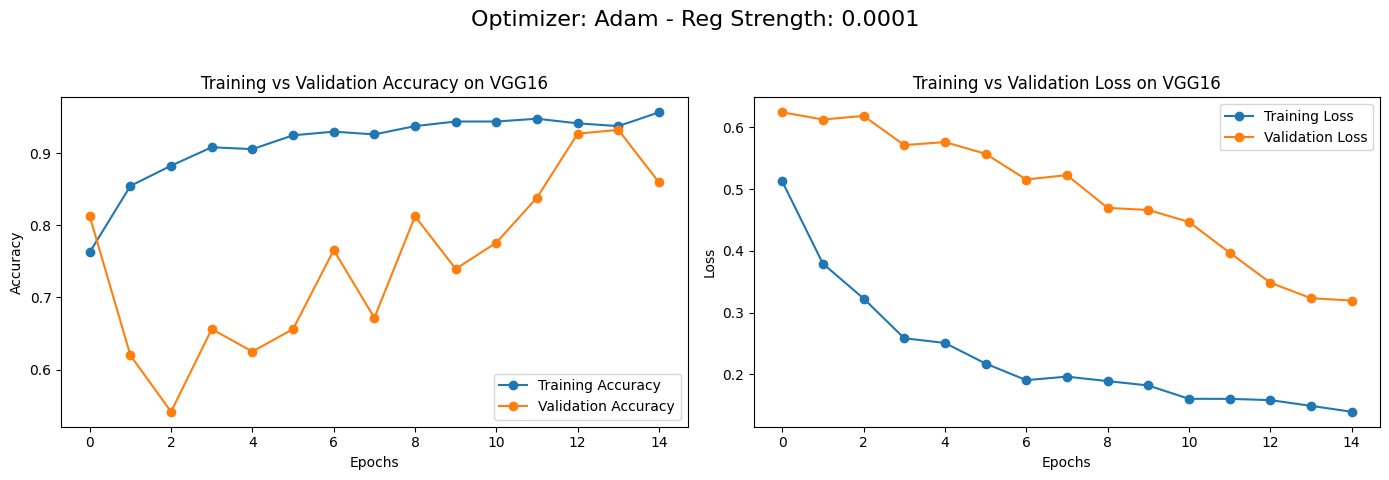

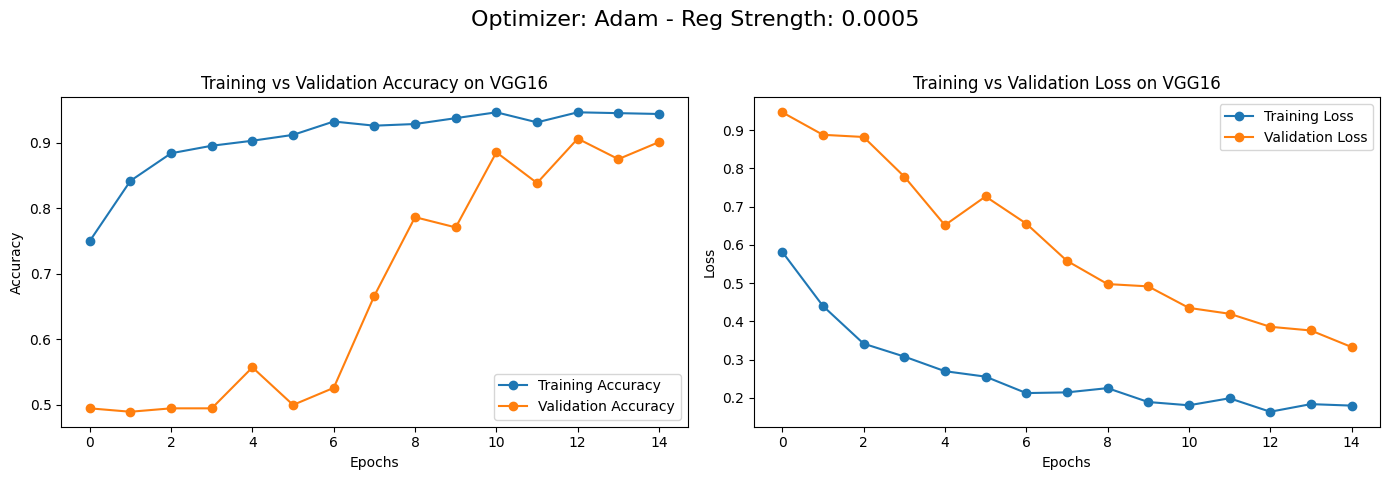

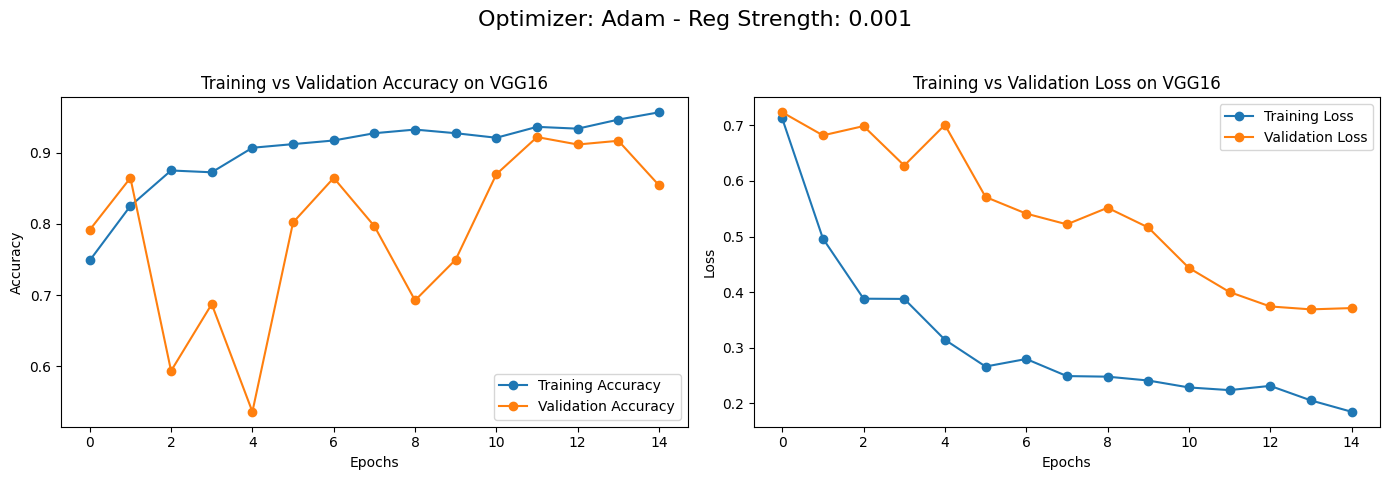

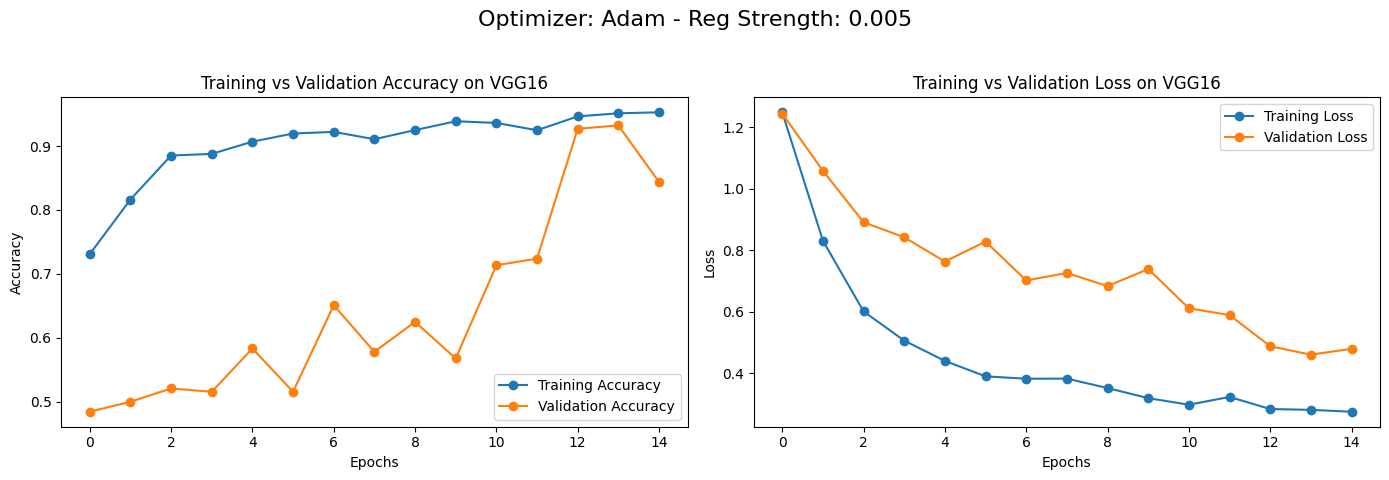

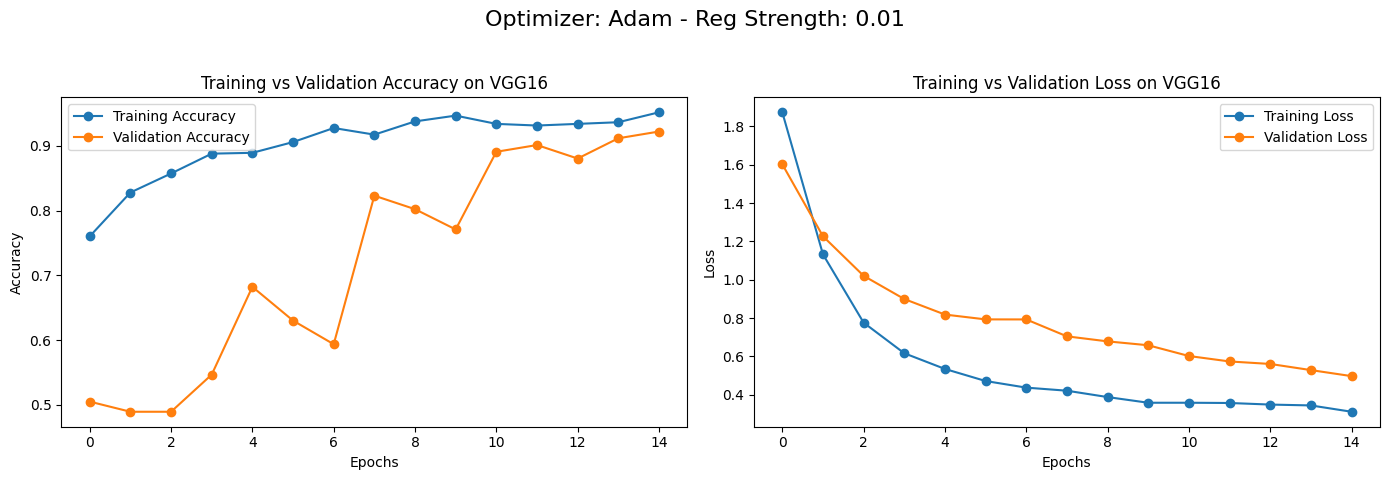

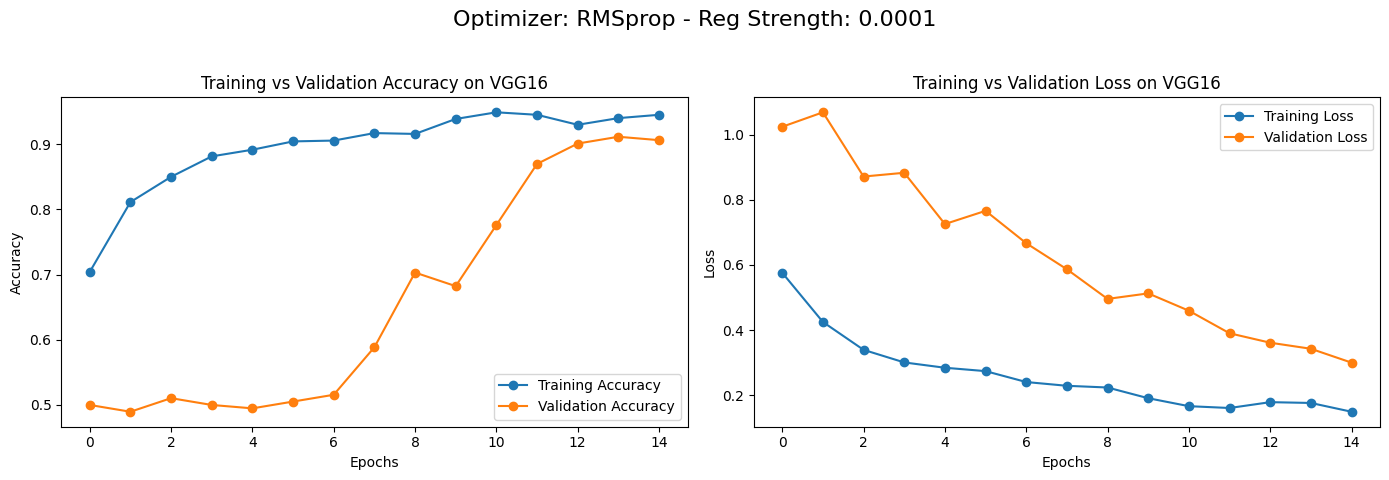

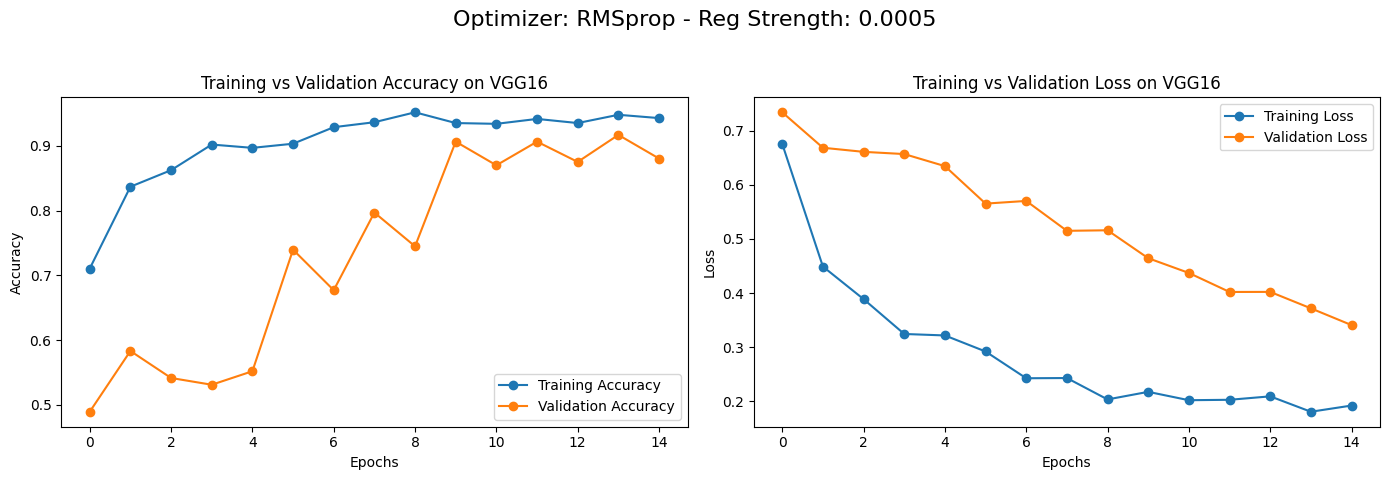

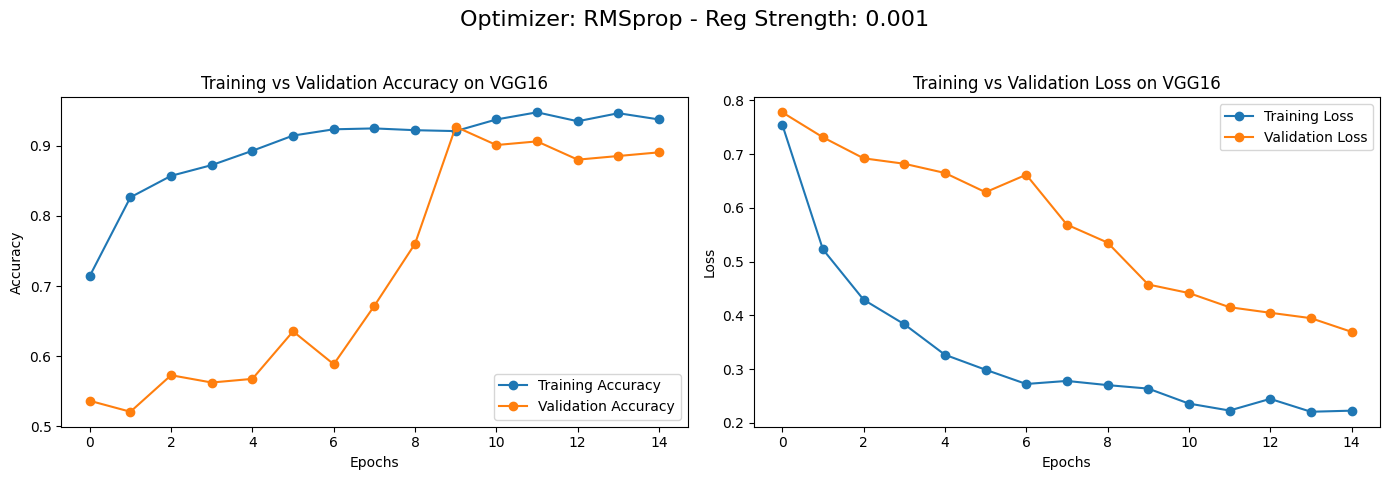

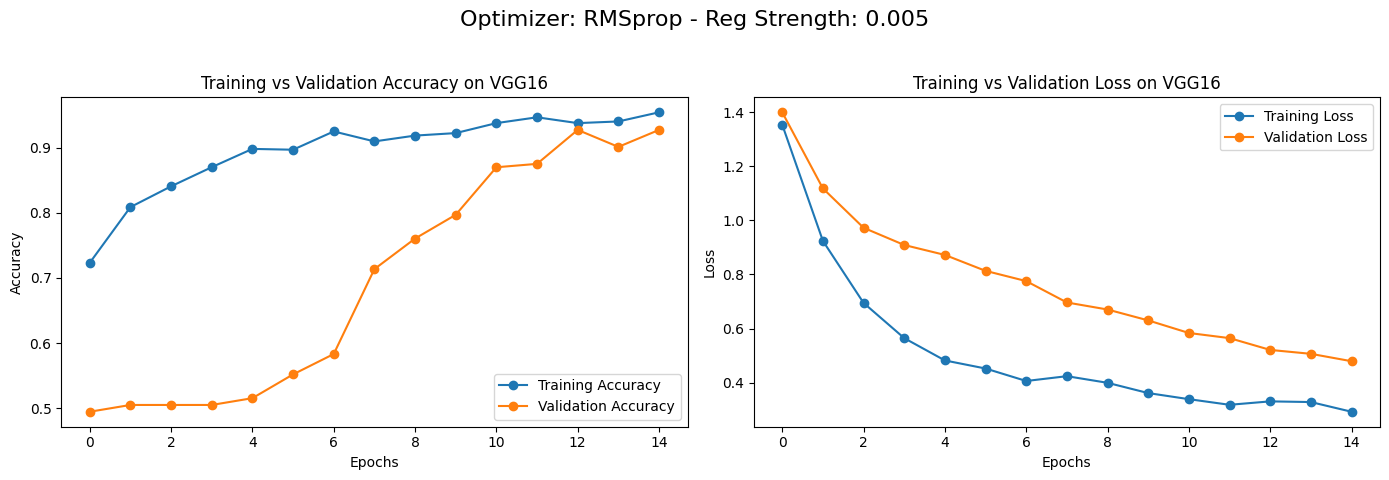

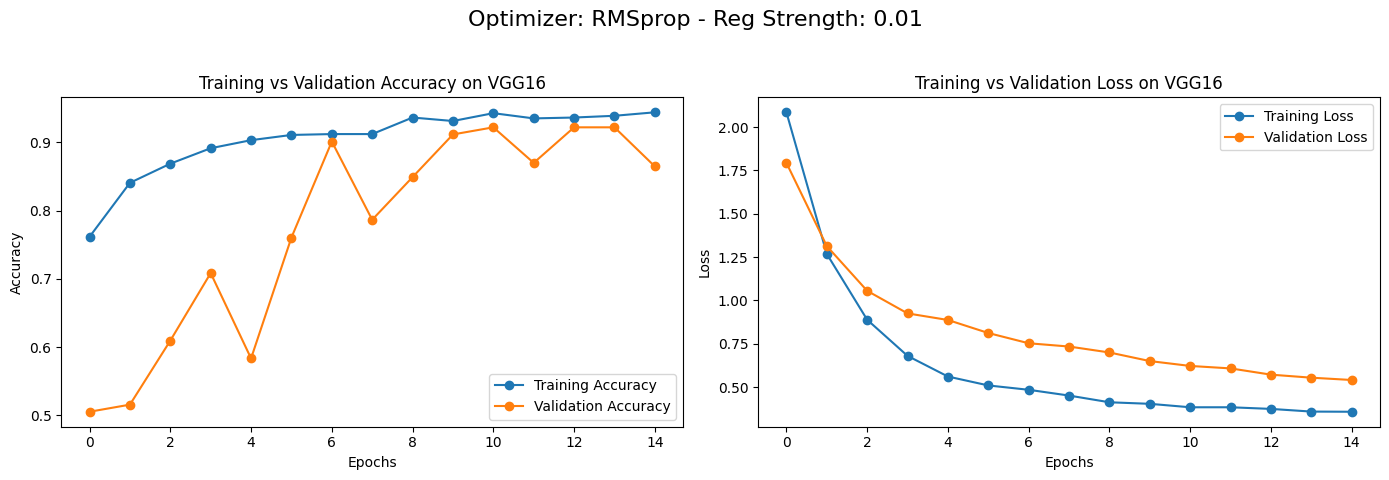

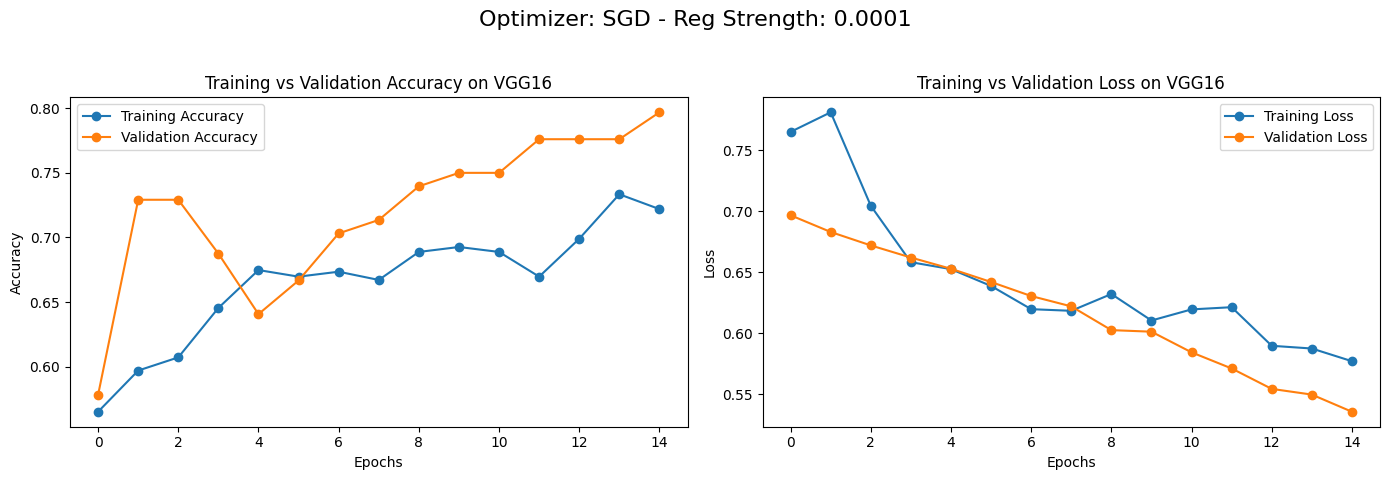

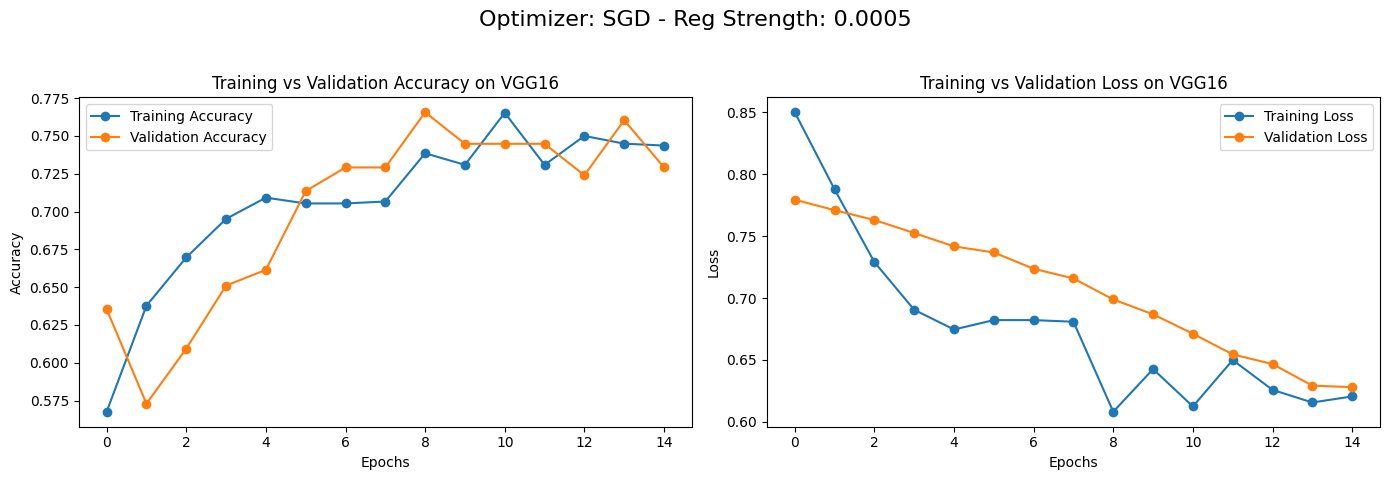

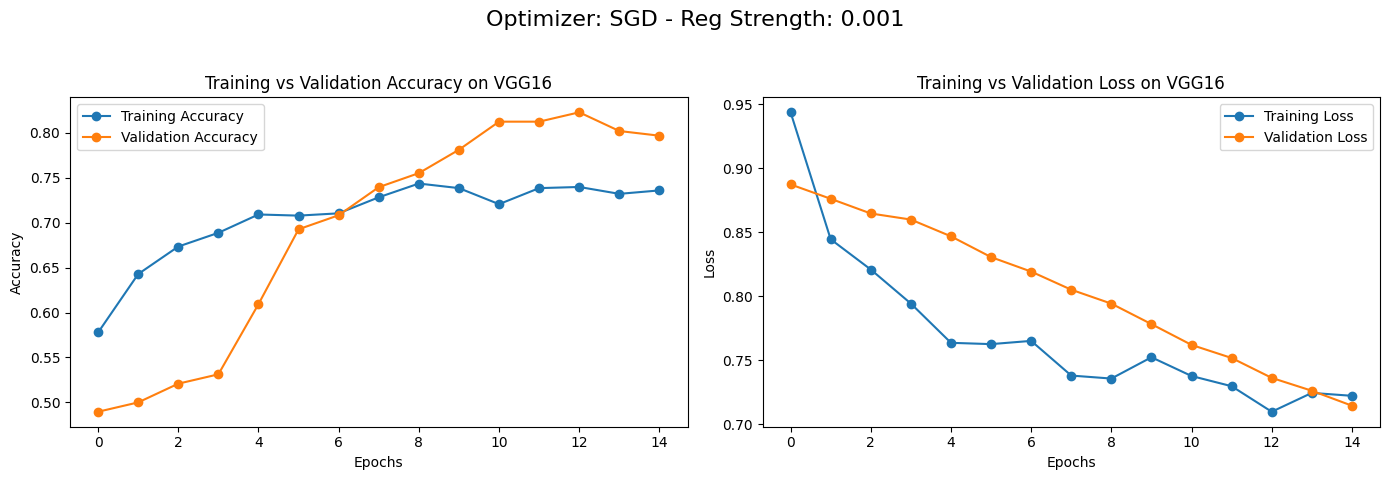

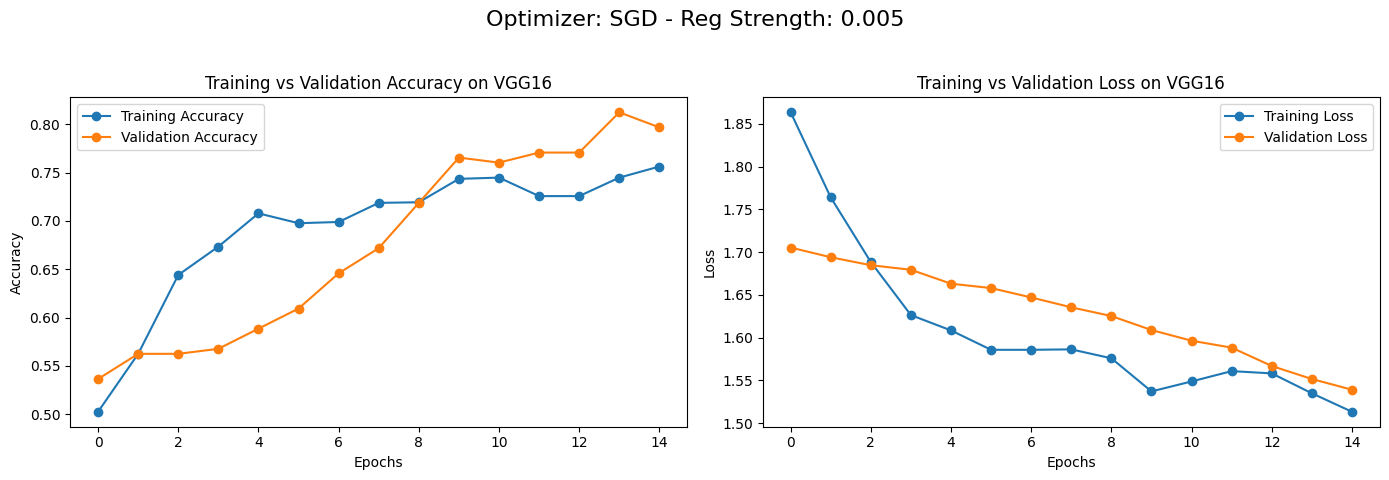

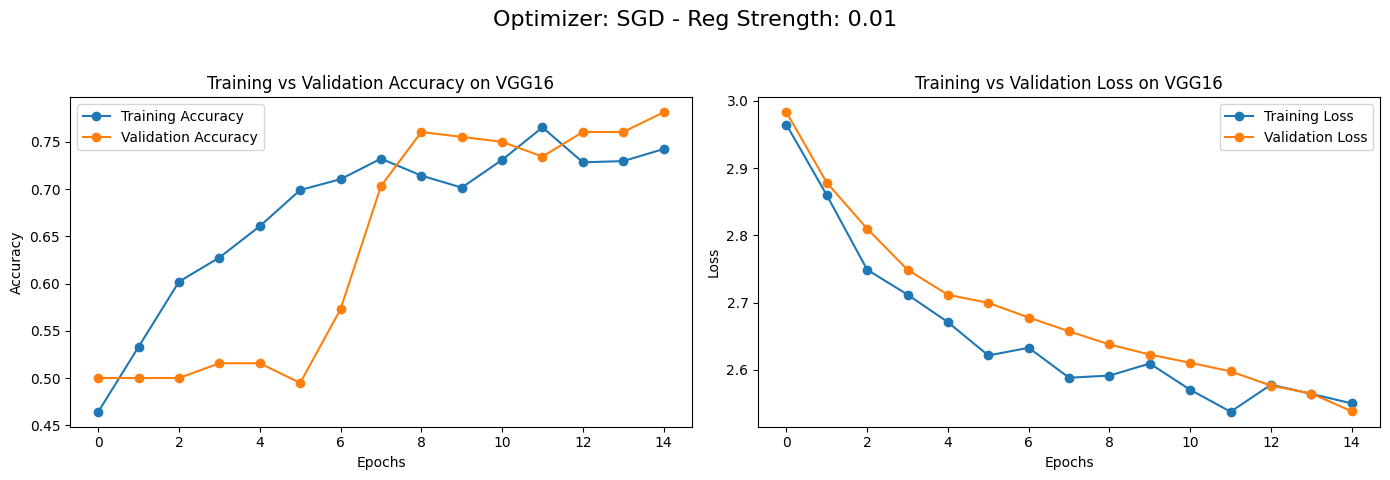

In [34]:
def plot_results_by_optimizer(optimizers, results):
    for optimizer in optimizers:
        optimizer_results = [r for r in results if r['optimizer'] == optimizer]
        for result in optimizer_results:
            fig, axes = plt.subplots(1, 2, figsize=(14, 5))
            fig.suptitle(f'Optimizer: {optimizer} - Reg Strength: {result["reg_strength"]}', fontsize=16)
            
            axes[0].plot(result['history']['accuracy'], label='Training Accuracy', marker='o')
            axes[0].plot(result['history']['val_accuracy'], label='Validation Accuracy', marker='o')
            axes[0].set_title('Training vs Validation Accuracy on VGG16')
            axes[0].set_xlabel('Epochs')
            axes[0].set_ylabel('Accuracy')
            axes[0].legend()
            
            axes[1].plot(result['history']['loss'], label='Training Loss', marker='o')
            axes[1].plot(result['history']['val_loss'], label='Validation Loss', marker='o')
            axes[1].set_title('Training vs Validation Loss on VGG16')
            axes[1].set_xlabel('Epochs')
            axes[1].set_ylabel('Loss')
            axes[1].legend()
            
            plt.tight_layout(rect=[0, 0.03, 1, 0.95])

            save_path = "Plots/Needs Respray/VGG16/"
            fig.savefig(f"{save_path}{optimizer}_{result['reg_strength']}.png")
            
            plt.show()

plot_results_by_optimizer(optimizers, results_vgg16)

Observing Inception-v3 model performance on different parameters

In [18]:
input_shape_inceptionv3 = (299, 299, 3)

training_data_inceptionv3 = train_datagen.flow_from_directory(directory = img_dir_train, target_size = (299, 299), color_mode = 'rgb', batch_size = BATCH_SIZE, class_mode = 'binary', subset='training', shuffle = True, seed = 42)
validation_data_inceptionv3 = train_datagen.flow_from_directory(directory = img_dir_train, target_size = (299, 299), color_mode = 'rgb', batch_size = BATCH_SIZE, class_mode = 'binary', subset='validation', shuffle = True, seed = 42)
testing_data_inceptionv3 = test_datagen.flow_from_directory(directory = img_dir_test, target_size = (299, 299), color_mode = 'rgb', class_mode = 'binary', shuffle = False, seed = 42)

n_steps = training_data_inceptionv3.samples // BATCH_SIZE
n_val_steps = validation_data_inceptionv3.samples // BATCH_SIZE

Found 816 images belonging to 2 classes.
Found 204 images belonging to 2 classes.
Found 8 images belonging to 2 classes.


In [19]:
#Inception-v3
def create_model_inceptionv3(input_shape, optimizer, lr, reg_strength=0.3):
    if optimizer == 'SGD':
        opt = SGD(learning_rate=lr)
    elif optimizer == 'RMSprop':
        opt = Adam(learning_rate=lr)
    elif optimizer == 'Adam':
        opt = RMSprop(learning_rate=lr)
    
    conv_base = InceptionV3(include_top=False,
                      weights='imagenet',
                      input_shape=input_shape)
    
    for layer in conv_base.layers:
        layer.trainable = False
        
    top_model = conv_base.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(128, activation='relu', kernel_regularizer=l2(reg_strength))(top_model)
    top_model = BatchNormalization()(top_model)
    top_model = Dropout(0.5)(top_model)
    output_layer = Dense(1, activation='sigmoid')(top_model)
    
    model = Model(inputs=conv_base.input, outputs=output_layer)
    
    model.compile(optimizer=opt,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [20]:
results_inceptionv3 = []

for reg_strength in regularization_strengths:
    for optimizer in optimizers:
        print(f"Training with {optimizer}, reg_strength={reg_strength}")
        model_inceptionv3 = create_model_inceptionv3(input_shape_inceptionv3, optimizer, learning_rate, reg_strength=reg_strength)
        lr_scheduler = step_decay_schedule(learning_rate, decay_factor, step_size)
        history_inceptionv3 = model_inceptionv3.fit(training_data_inceptionv3,
                            validation_data=validation_data_inceptionv3,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            epochs=n_epochs,
                            callbacks=[lr_scheduler],
                            verbose=1)
        results_inceptionv3.append({'optimizer': optimizer,
                        'reg_strength': reg_strength,
                        'history': history_inceptionv3.history})
        

Training with Adam, reg_strength=0.0001
Epoch 1/15
25/25 [==============================] - 19s 640ms/step - loss: 0.4321 - accuracy: 0.8151 - val_loss: 0.3047 - val_accuracy: 0.8594 - lr: 0.0010
Epoch 2/15
25/25 [==============================] - 15s 615ms/step - loss: 0.2089 - accuracy: 0.9222 - val_loss: 0.2335 - val_accuracy: 0.9115 - lr: 0.0010
Epoch 3/15
25/25 [==============================] - 15s 594ms/step - loss: 0.1537 - accuracy: 0.9452 - val_loss: 0.2114 - val_accuracy: 0.9167 - lr: 0.0010
Epoch 4/15
25/25 [==============================] - 15s 594ms/step - loss: 0.1245 - accuracy: 0.9605 - val_loss: 0.2014 - val_accuracy: 0.9167 - lr: 0.0010
Epoch 5/15
25/25 [==============================] - 15s 596ms/step - loss: 0.0897 - accuracy: 0.9796 - val_loss: 0.2557 - val_accuracy: 0.8958 - lr: 0.0010
Epoch 6/15
25/25 [==============================] - 15s 595ms/step - loss: 0.0805 - accuracy: 0.9796 - val_loss: 0.1554 - val_accuracy: 0.9375 - lr: 5.0000e-04
Epoch 7/15
25/25 [==

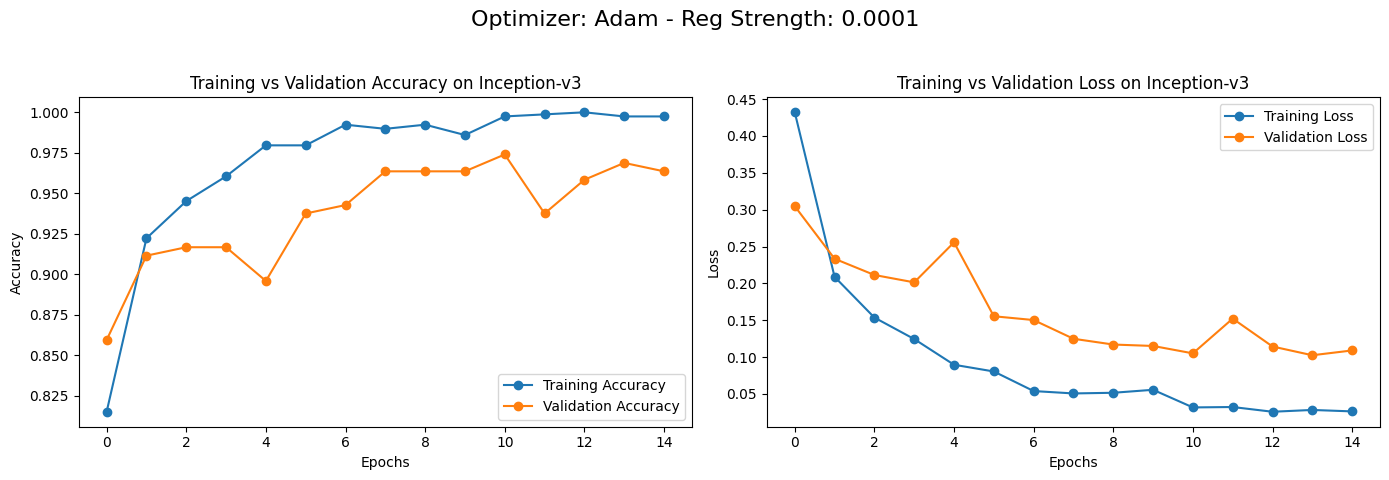

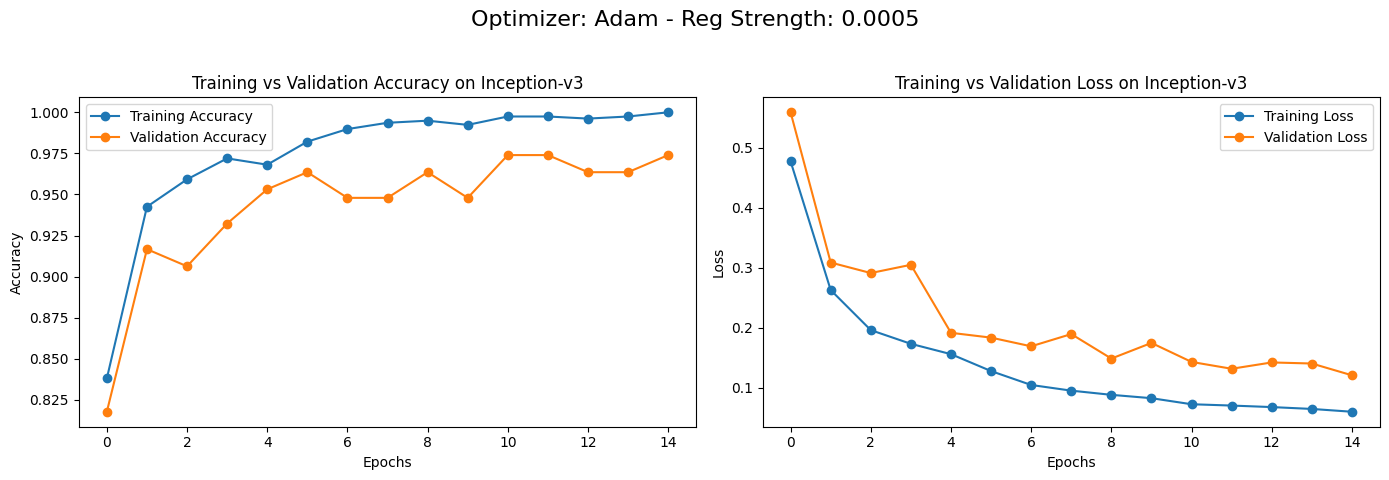

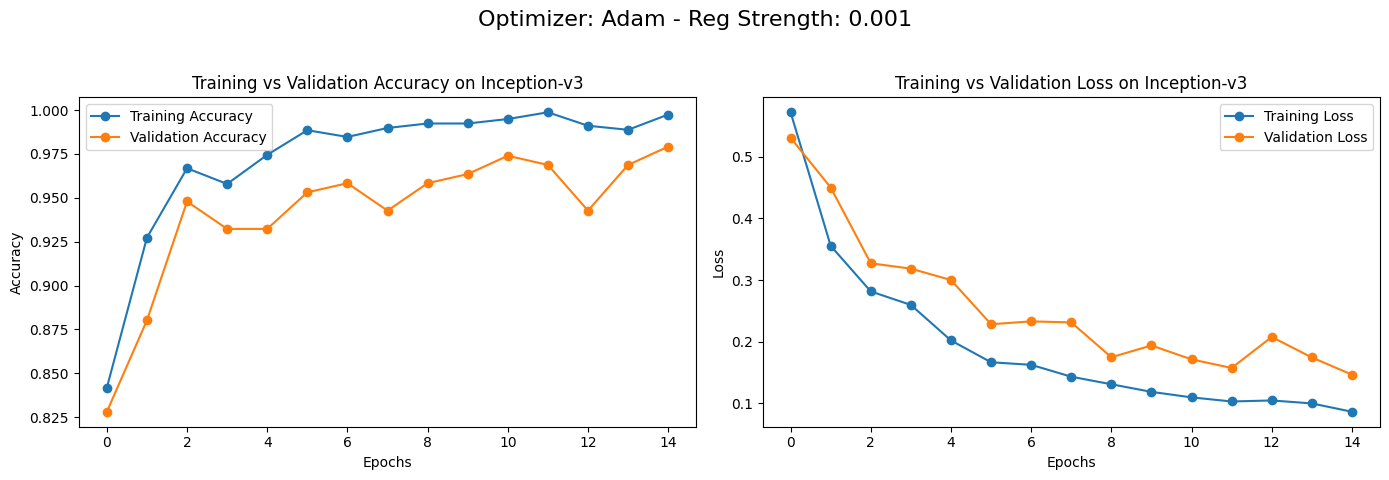

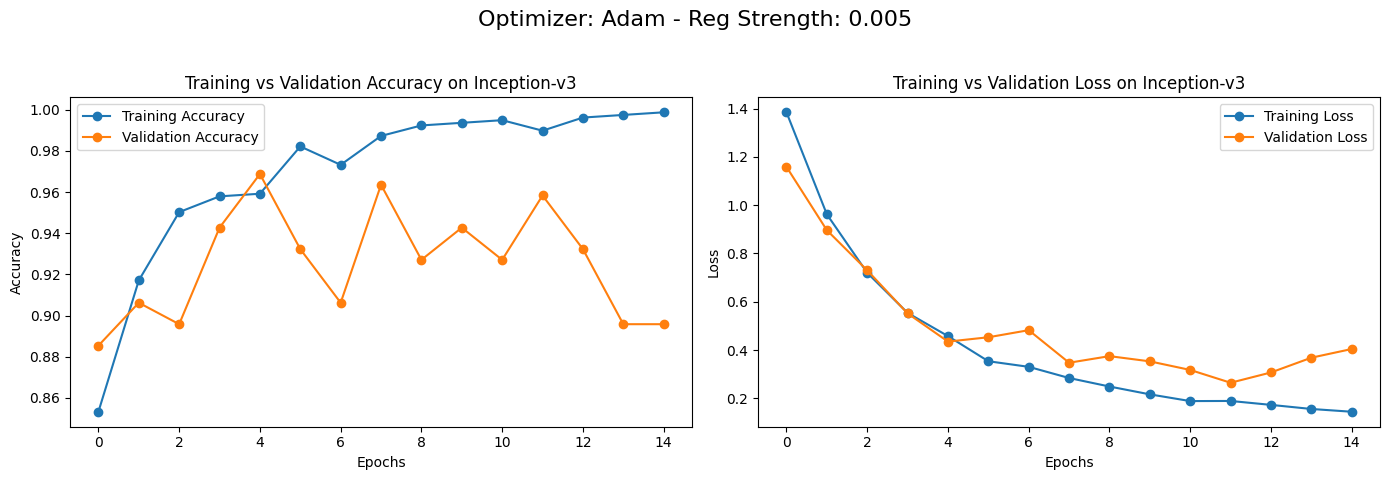

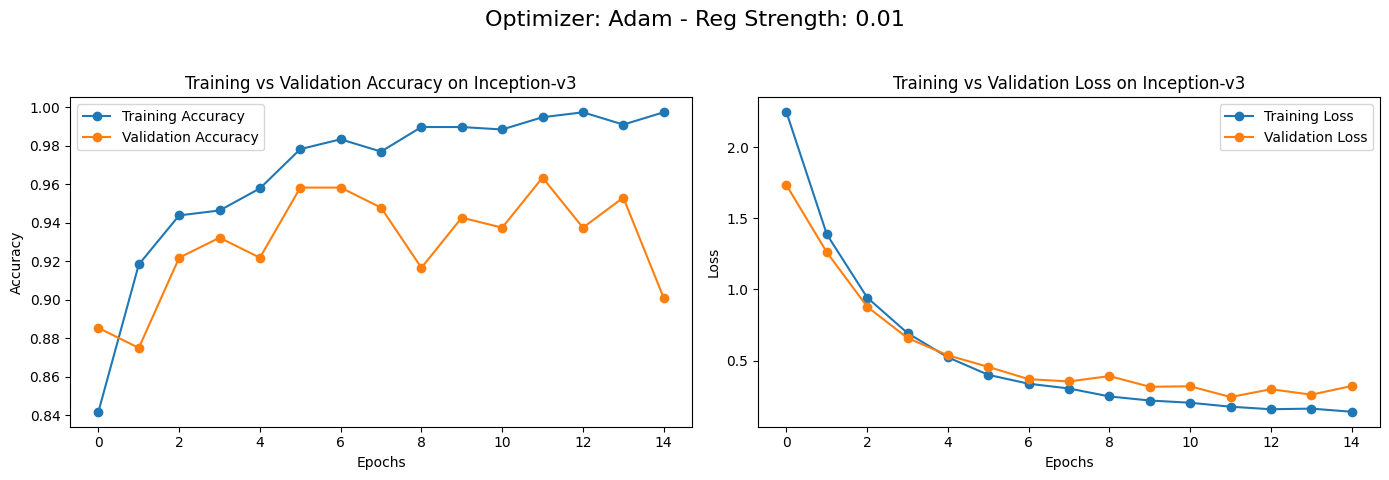

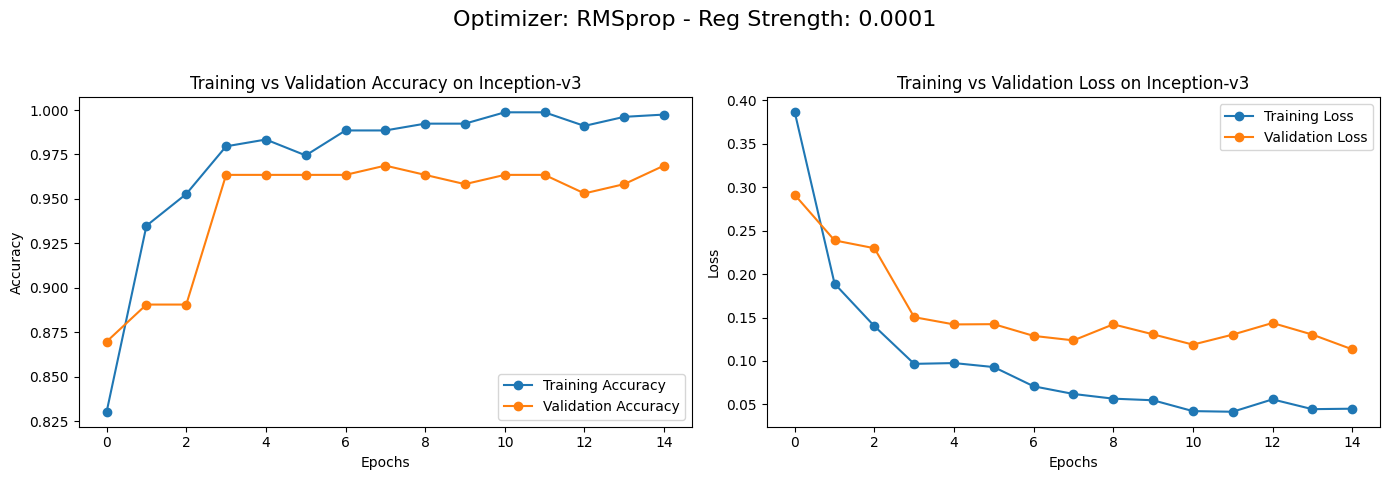

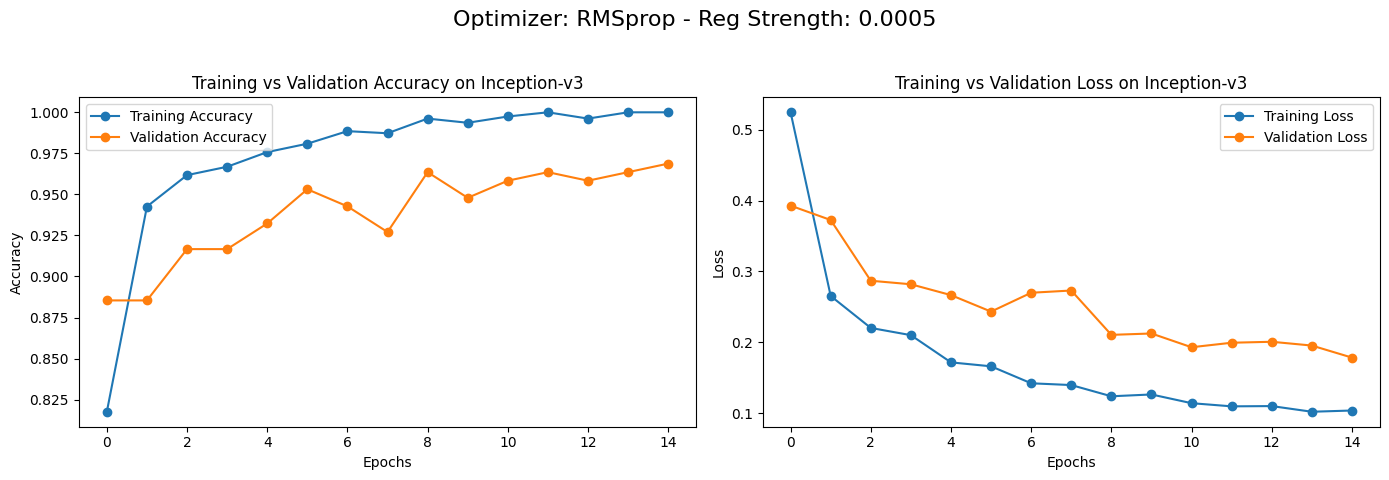

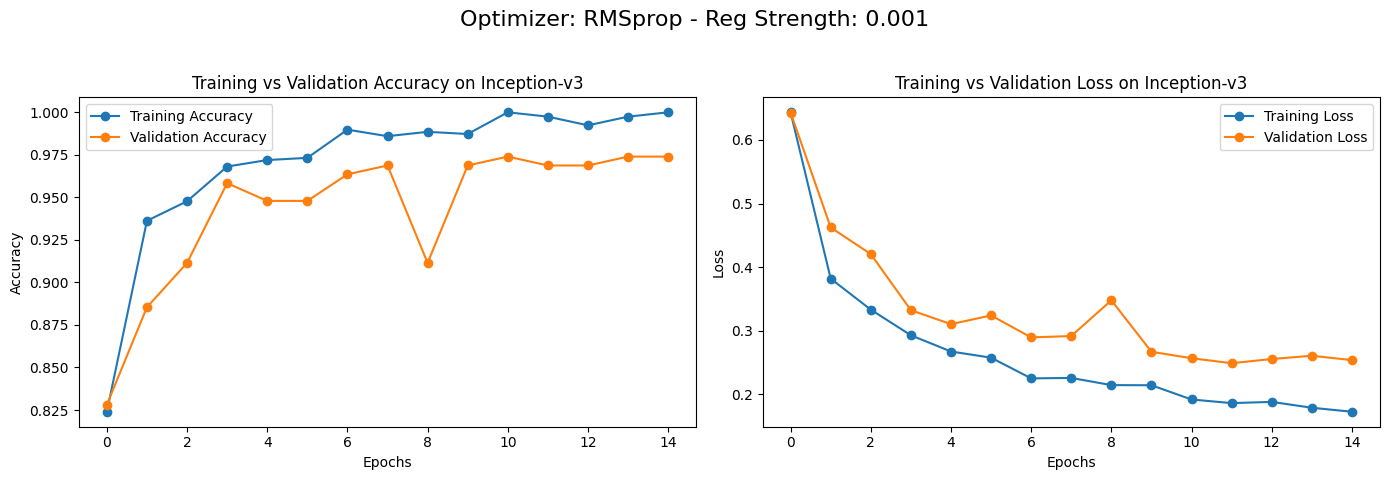

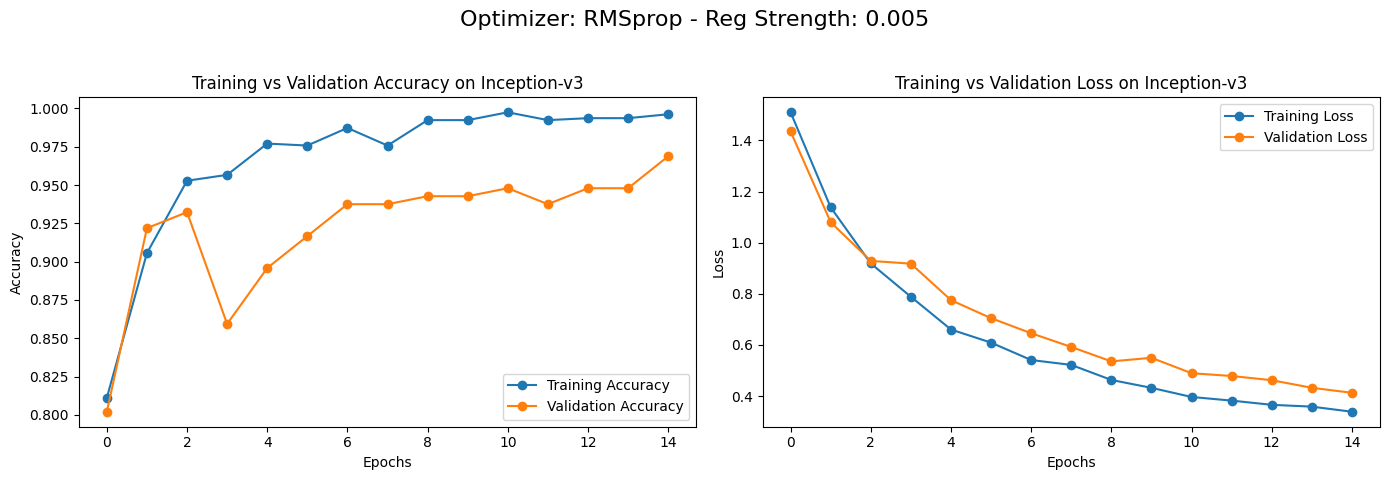

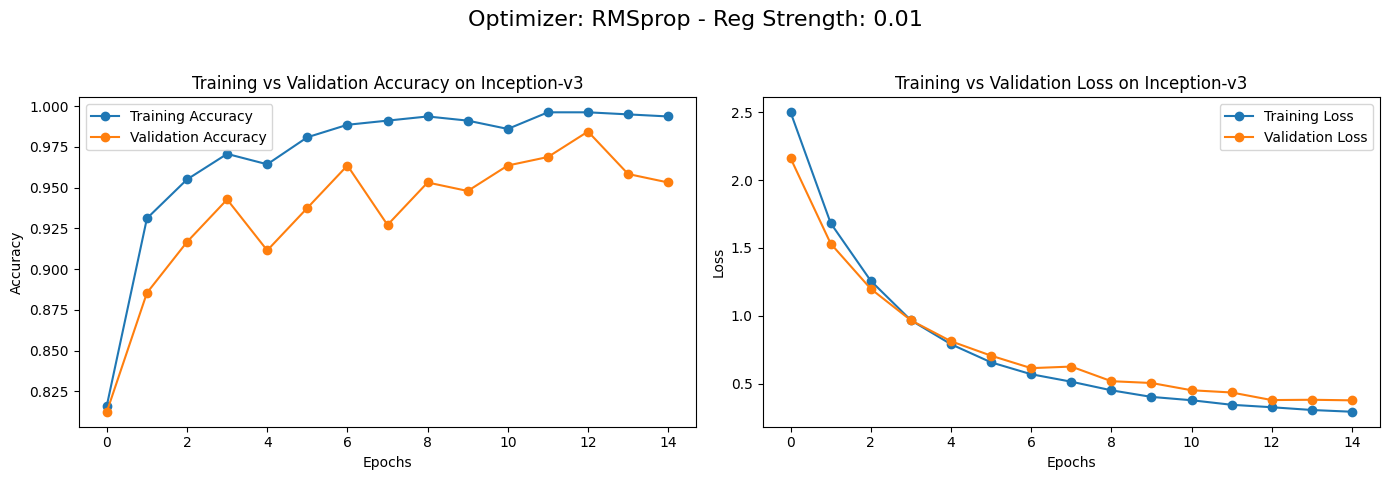

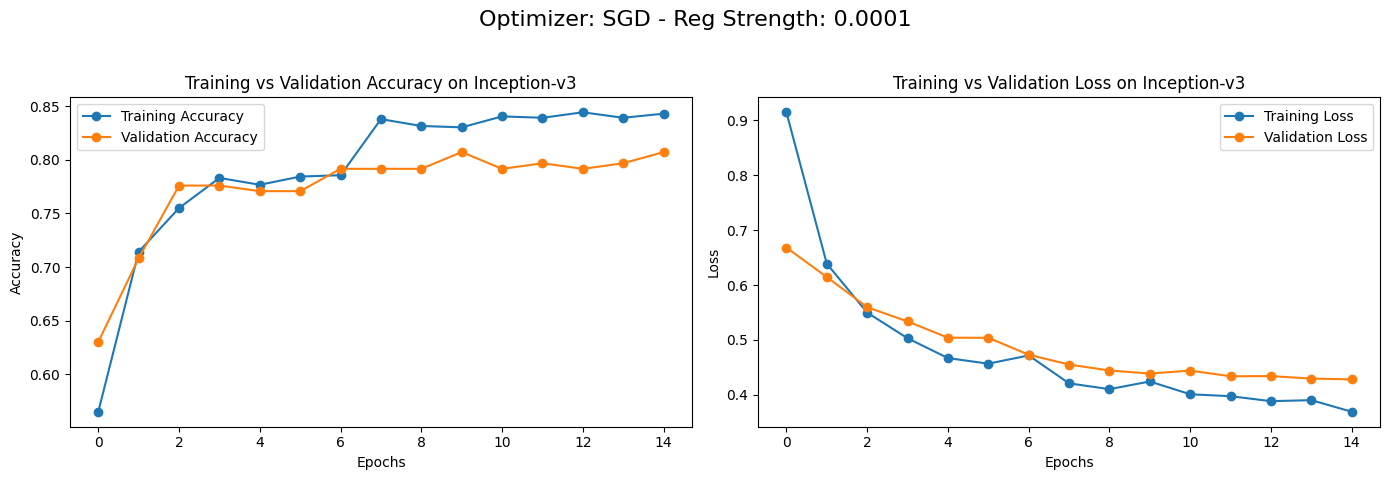

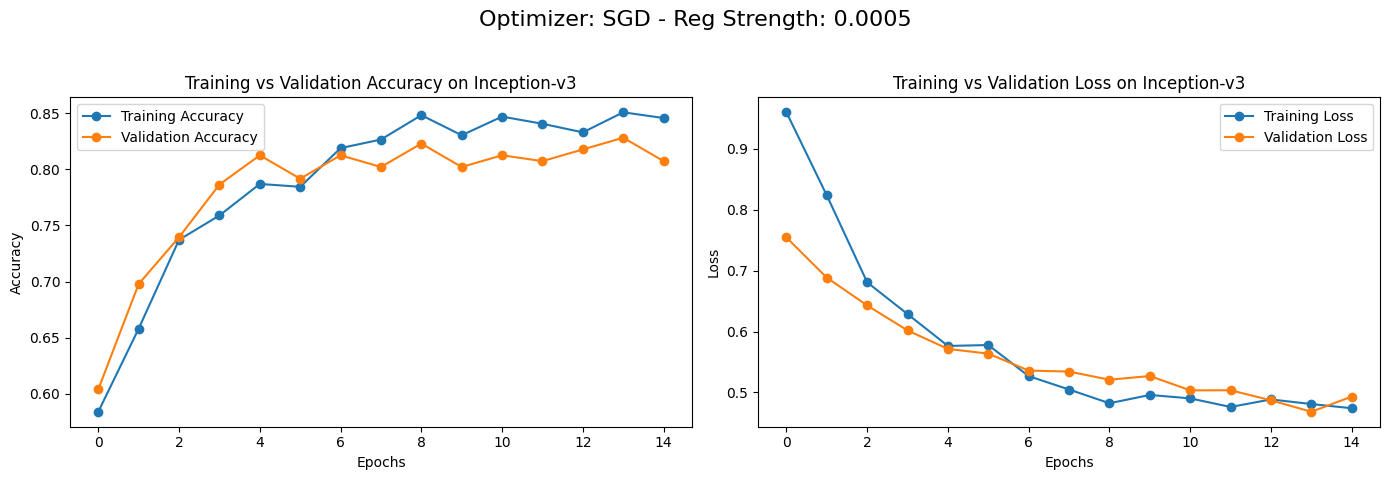

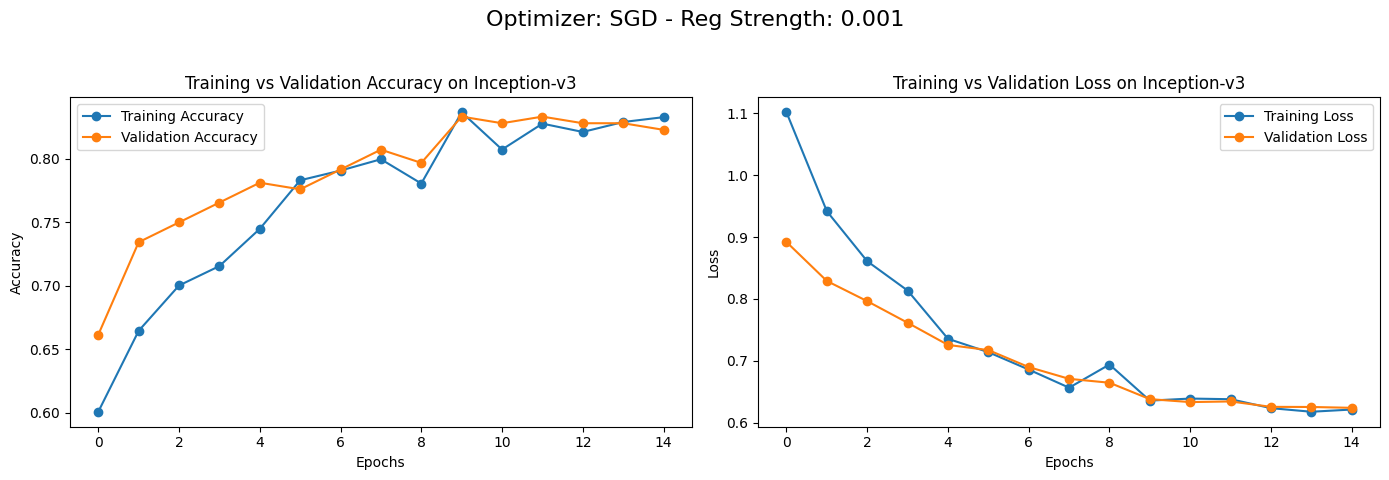

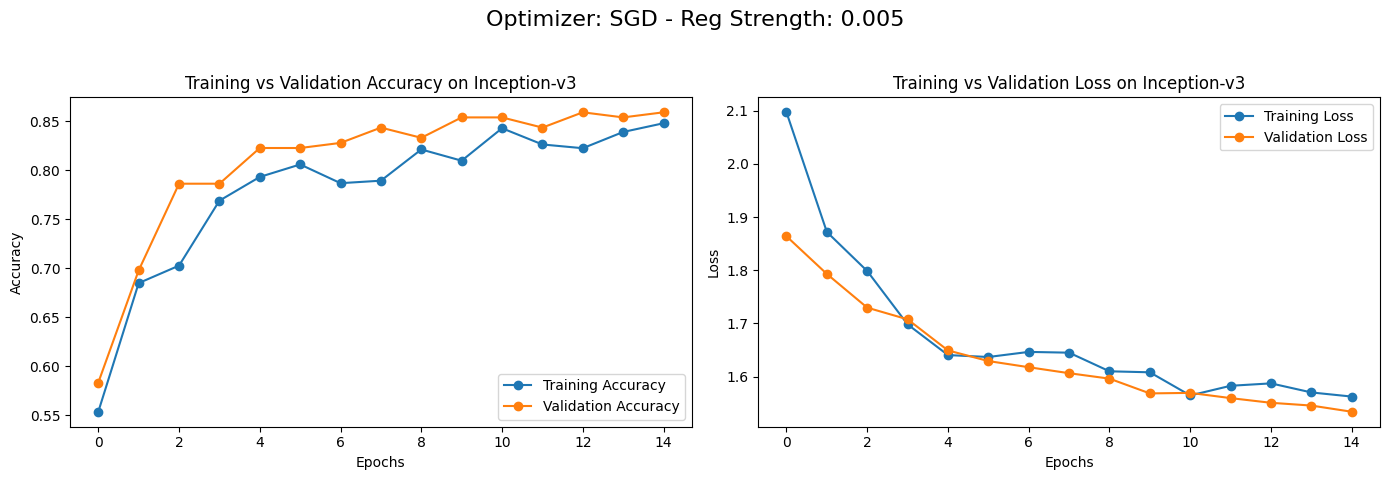

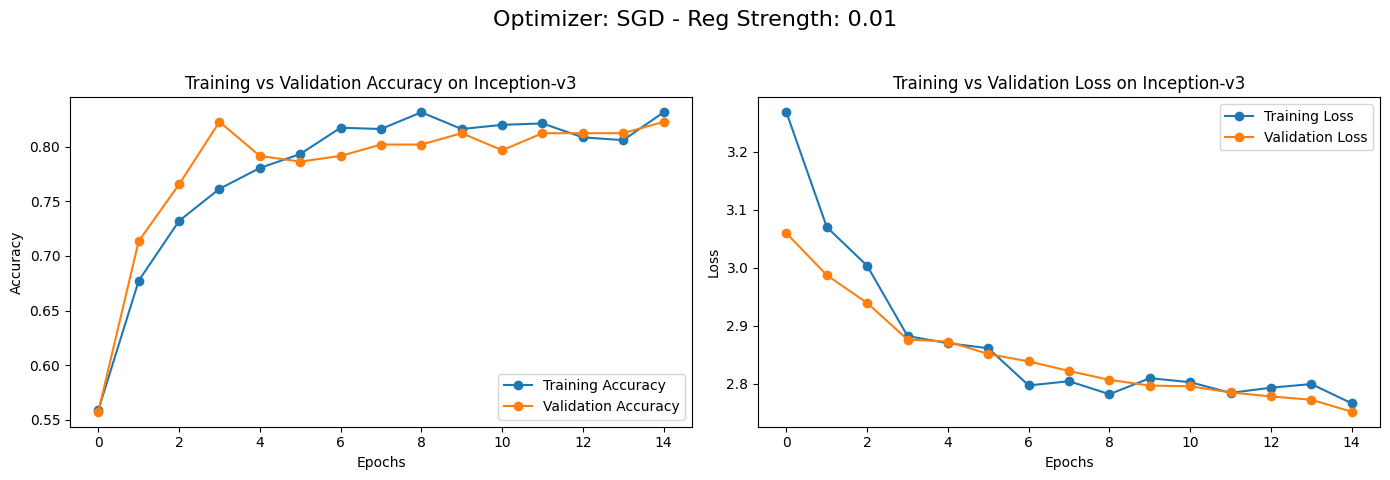

In [35]:
def plot_results_by_optimizer(optimizers, results):
    for optimizer in optimizers:
        optimizer_results = [r for r in results if r['optimizer'] == optimizer]
        for result in optimizer_results:
            fig, axes = plt.subplots(1, 2, figsize=(14, 5))
            fig.suptitle(f'Optimizer: {optimizer} - Reg Strength: {result["reg_strength"]}', fontsize=16)
            
            axes[0].plot(result['history']['accuracy'], label='Training Accuracy', marker='o')
            axes[0].plot(result['history']['val_accuracy'], label='Validation Accuracy', marker='o')
            axes[0].set_title('Training vs Validation Accuracy on Inception-v3')
            axes[0].set_xlabel('Epochs')
            axes[0].set_ylabel('Accuracy')
            axes[0].legend()
            
            axes[1].plot(result['history']['loss'], label='Training Loss', marker='o')
            axes[1].plot(result['history']['val_loss'], label='Validation Loss', marker='o')
            axes[1].set_title('Training vs Validation Loss on Inception-v3')
            axes[1].set_xlabel('Epochs')
            axes[1].set_ylabel('Loss')
            axes[1].legend()
            
            plt.tight_layout(rect=[0, 0.03, 1, 0.95])

            save_path = "Plots/Needs Respray/InceptionV3/"
            fig.savefig(f"{save_path}{optimizer}_{result['reg_strength']}.png")
            
            plt.show()

plot_results_by_optimizer(optimizers, results_inceptionv3)

Observing DenseNet121 model performance on different parameters

In [22]:
input_shape_densenet = (224, 224, 3)

training_data_densenet = train_datagen.flow_from_directory(directory = img_dir_train, target_size = (224, 224), color_mode = 'rgb', batch_size = BATCH_SIZE, class_mode = 'binary', subset='training', shuffle = True, seed = 42)
validation_data_densenet = train_datagen.flow_from_directory(directory = img_dir_train, target_size = (224, 224), color_mode = 'rgb', batch_size = BATCH_SIZE, class_mode = 'binary', subset='validation', shuffle = True, seed = 42)
testing_data_densenet = train_datagen.flow_from_directory(directory = img_dir_test, target_size = (224, 224), color_mode = 'rgb', class_mode = 'binary', shuffle = False, seed = 42)
n_steps = training_data_densenet.samples // BATCH_SIZE
n_val_steps = validation_data_densenet.samples // BATCH_SIZE

Found 816 images belonging to 2 classes.
Found 204 images belonging to 2 classes.
Found 8 images belonging to 2 classes.


In [23]:
#DenseNet
def create_model_densenet(input_shape, optimizer, lr, reg_strength=0.3):
    if optimizer == 'SGD':
        opt = SGD(learning_rate=lr)
    elif optimizer == 'RMSprop':
        opt = Adam(learning_rate=lr)
    elif optimizer == 'Adam':
        opt = RMSprop(learning_rate=lr)
    
    conv_base = DenseNet121(include_top=False,
                      weights='imagenet',
                      input_shape=input_shape)
    
    for layer in conv_base.layers:
        layer.trainable = False
        
    top_model = conv_base.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(128, activation='relu', kernel_regularizer=l2(reg_strength))(top_model)
    top_model = BatchNormalization()(top_model)
    top_model = Dropout(0.5)(top_model)
    output_layer = Dense(1, activation='sigmoid')(top_model)
    
    model = Model(inputs=conv_base.input, outputs=output_layer)
    
    model.compile(optimizer=opt,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [24]:
results_densenet = []

for reg_strength in regularization_strengths:
    for optimizer in optimizers:
        print(f"Training with {optimizer}, reg_strength={reg_strength}")
        model_densenet = create_model_densenet(input_shape_densenet, optimizer, learning_rate, reg_strength=reg_strength)
        lr_scheduler = step_decay_schedule(learning_rate, decay_factor, step_size)
        history_densenet = model_densenet.fit(training_data_densenet,
                            validation_data=validation_data_densenet,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            epochs=n_epochs,
                            callbacks=[lr_scheduler],
                            verbose=1)
        results_densenet.append({'optimizer': optimizer,
                        'reg_strength': reg_strength,
                        'history': history_densenet.history})

Training with Adam, reg_strength=0.0001
29084464/29084464 [==============================] - 5s 0us/step
Epoch 1/15
25/25 [==============================] - 20s 649ms/step - loss: 0.4249 - accuracy: 0.8240 - val_loss: 0.3493 - val_accuracy: 0.8542 - lr: 0.0010
Epoch 2/15
25/25 [==============================] - 14s 579ms/step - loss: 0.2230 - accuracy: 0.9298 - val_loss: 0.2836 - val_accuracy: 0.8594 - lr: 0.0010
Epoch 3/15
25/25 [==============================] - 15s 581ms/step - loss: 0.1851 - accuracy: 0.9324 - val_loss: 0.2570 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 4/15
25/25 [==============================] - 14s 578ms/step - loss: 0.1368 - accuracy: 0.9579 - val_loss: 0.3831 - val_accuracy: 0.7969 - lr: 0.0010
Epoch 5/15
25/25 [==============================] - 14s 580ms/step - loss: 0.1198 - accuracy: 0.9643 - val_loss: 0.2158 - val_accuracy: 0.8906 - lr: 0.0010
Epoch 6/15
25/25 [==============================] - 15s 586ms/step - loss: 0.1061 - accuracy: 0.9643 - val_loss: 0.

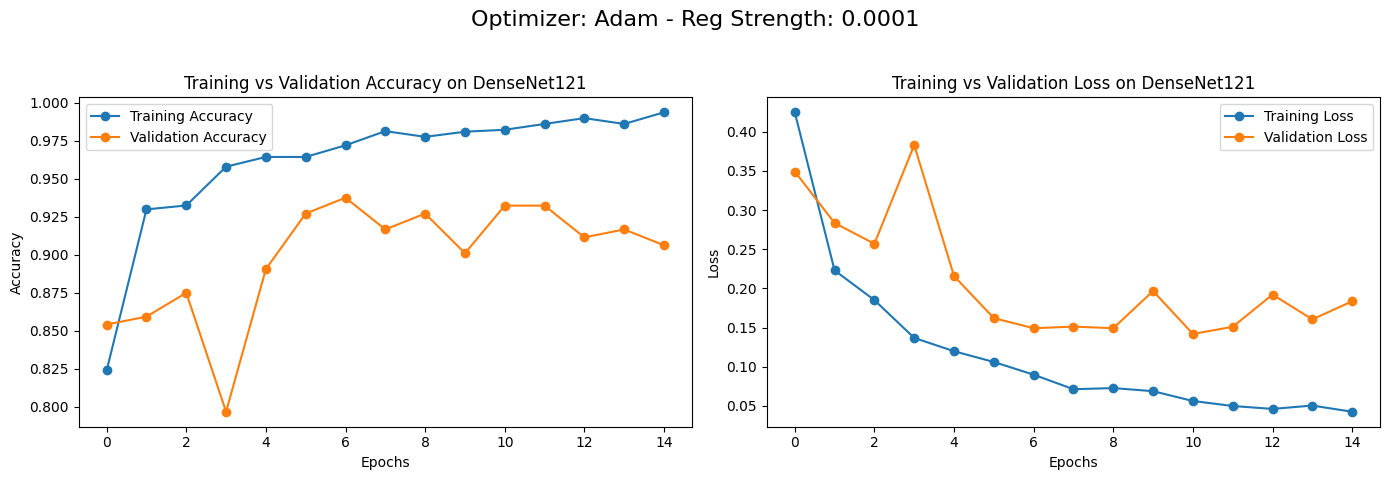

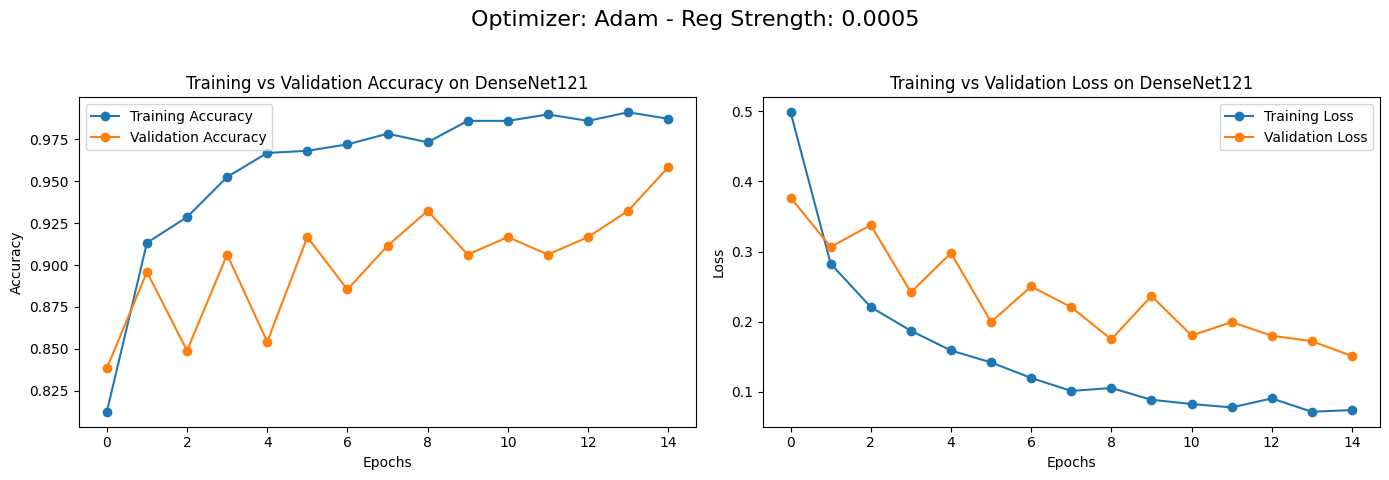

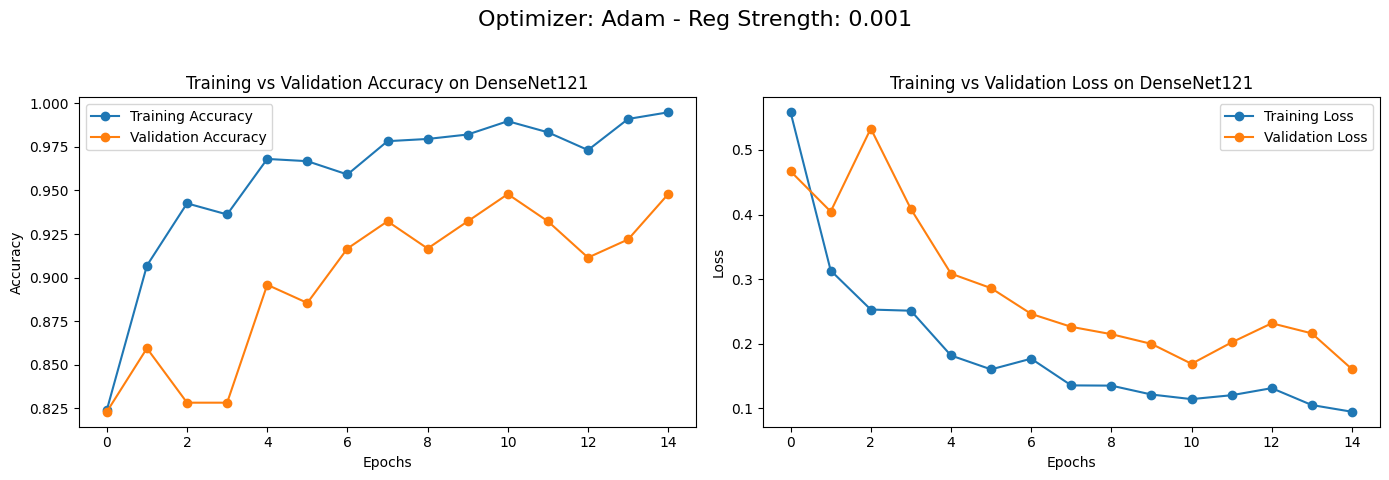

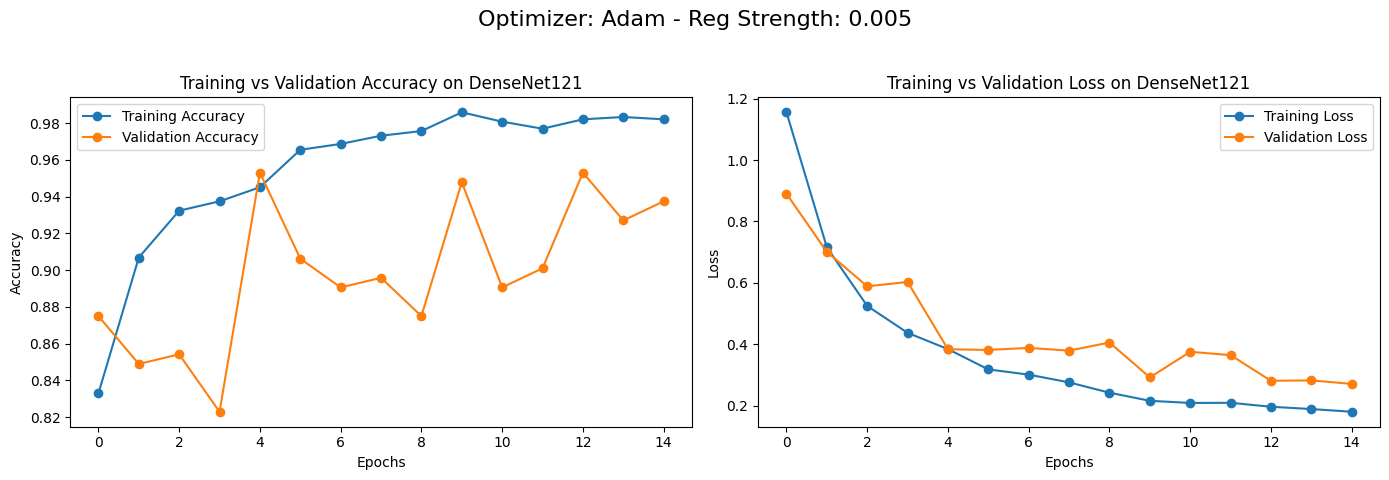

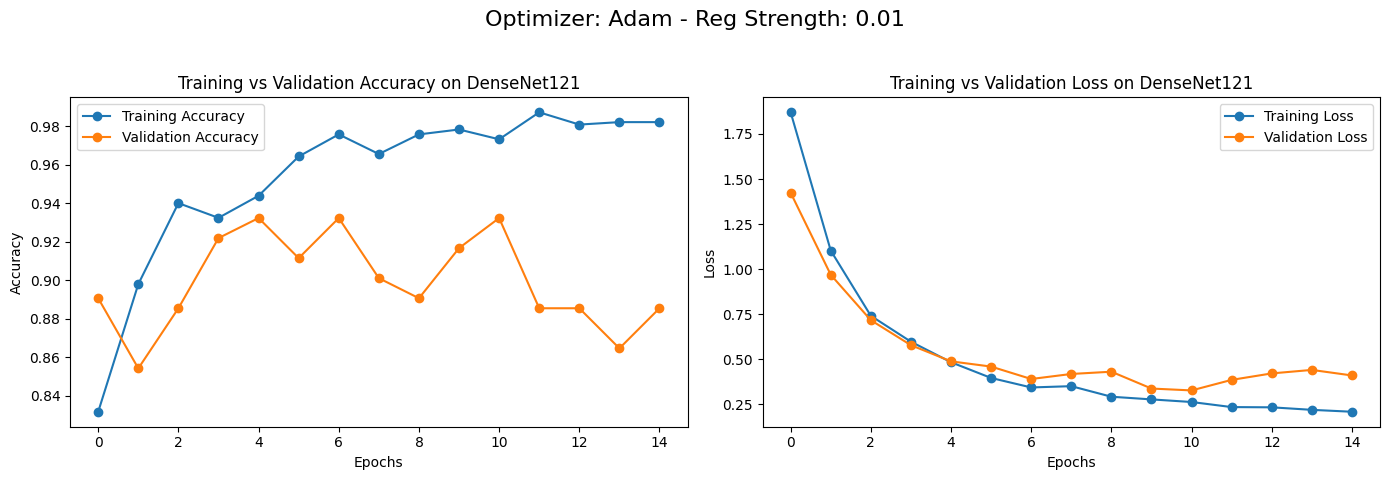

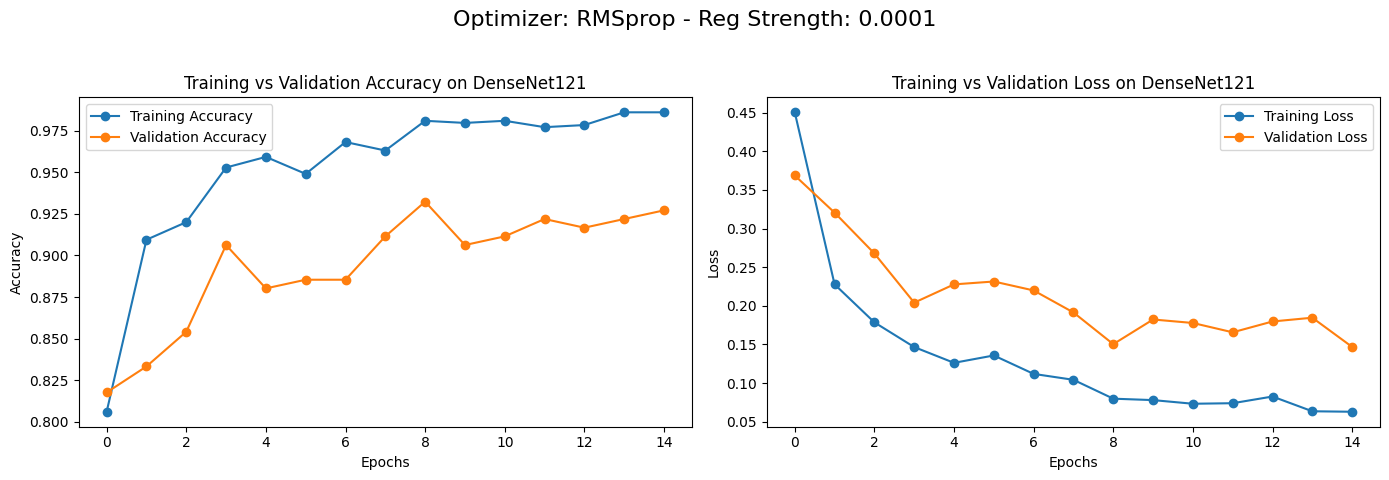

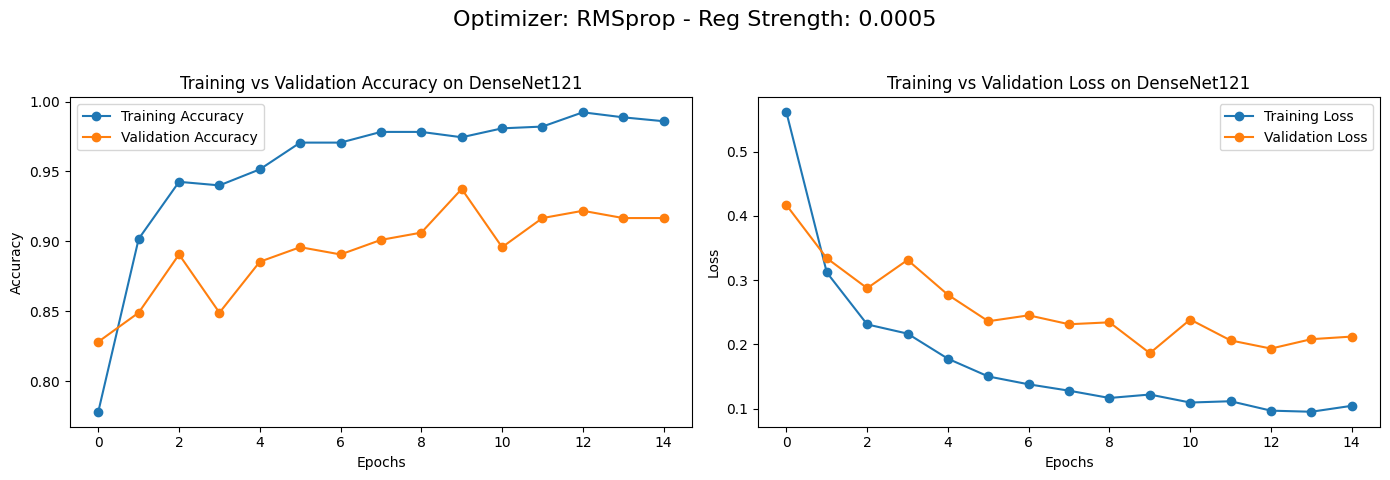

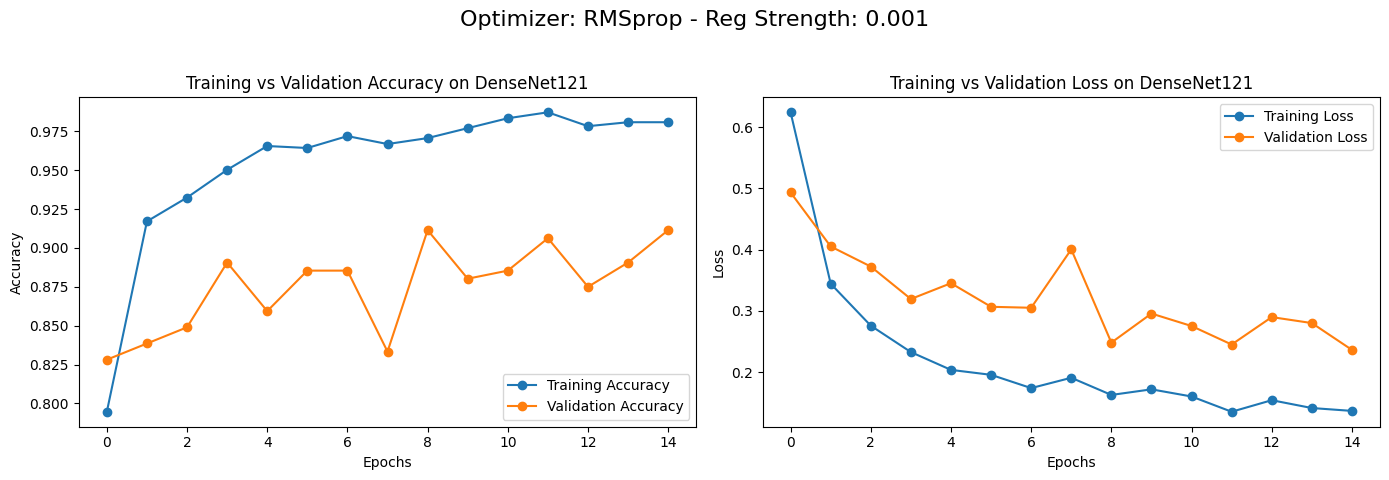

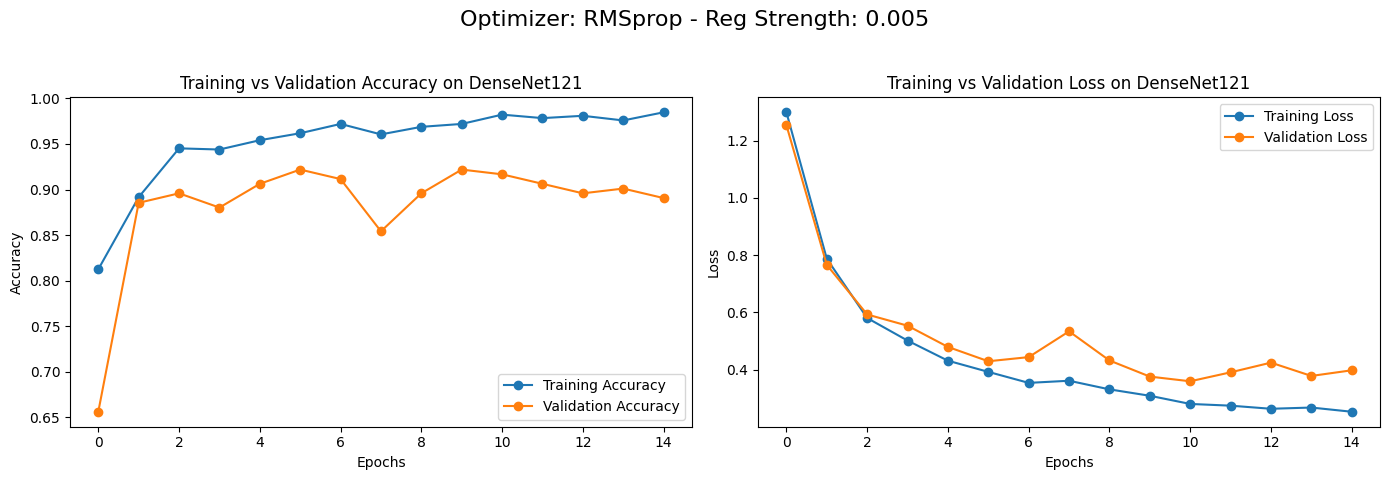

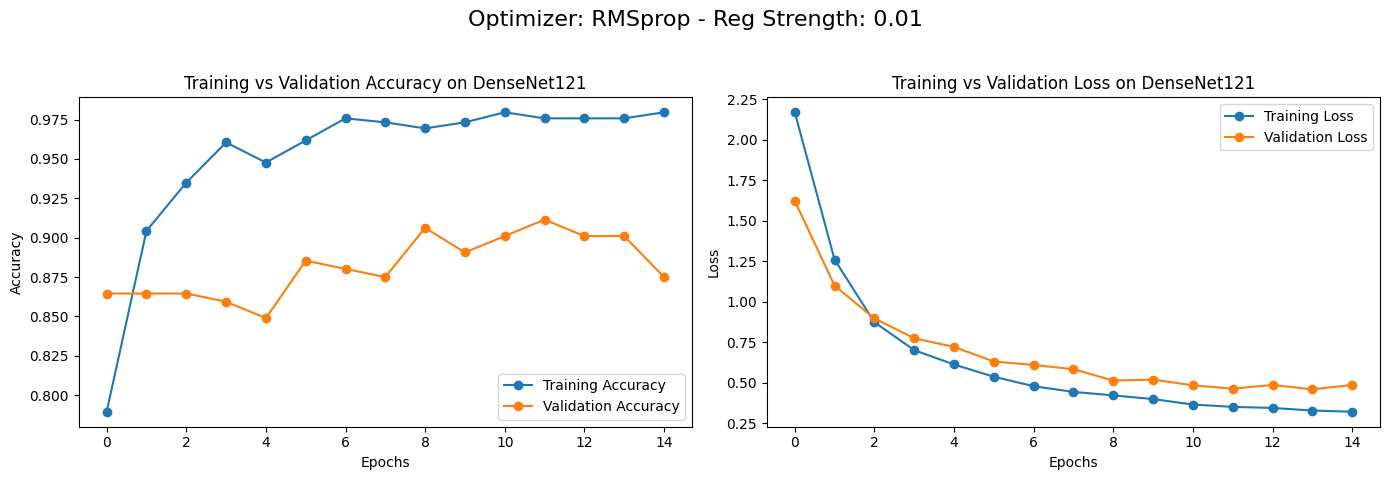

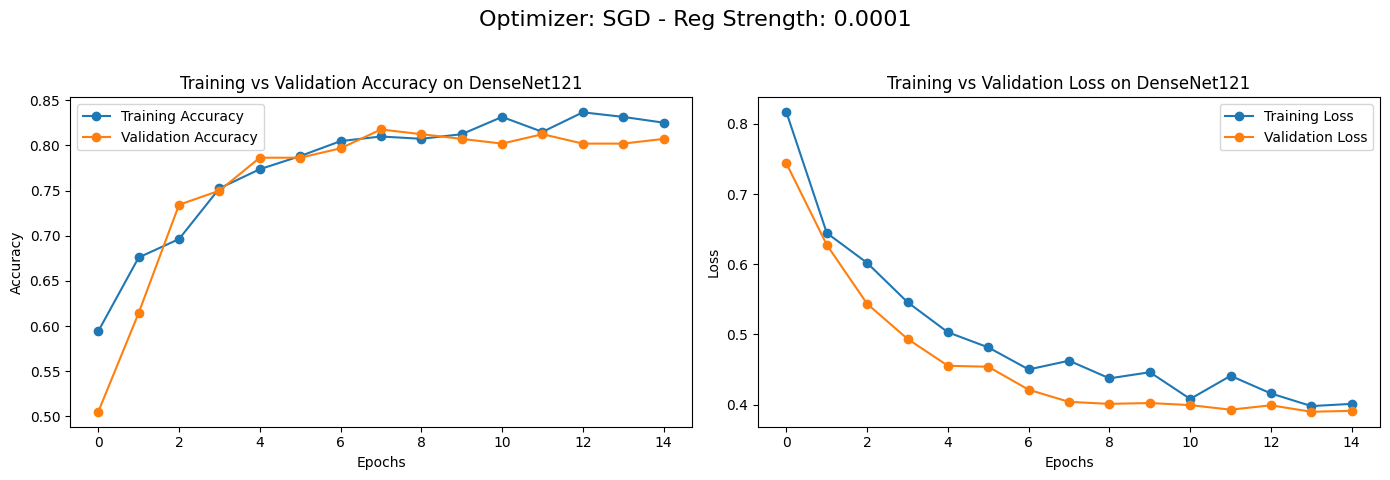

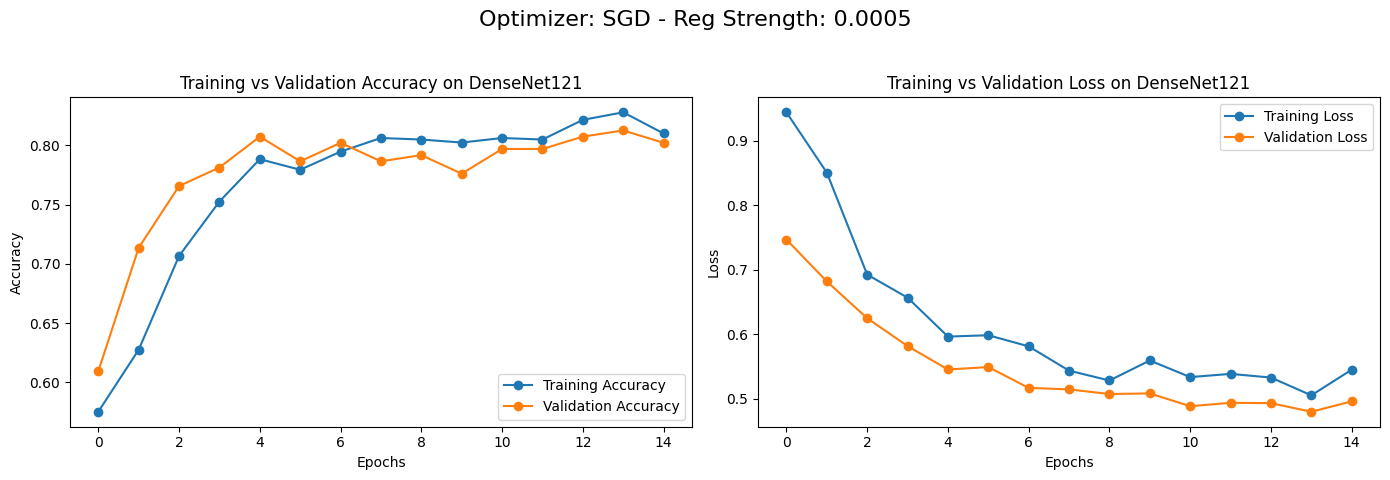

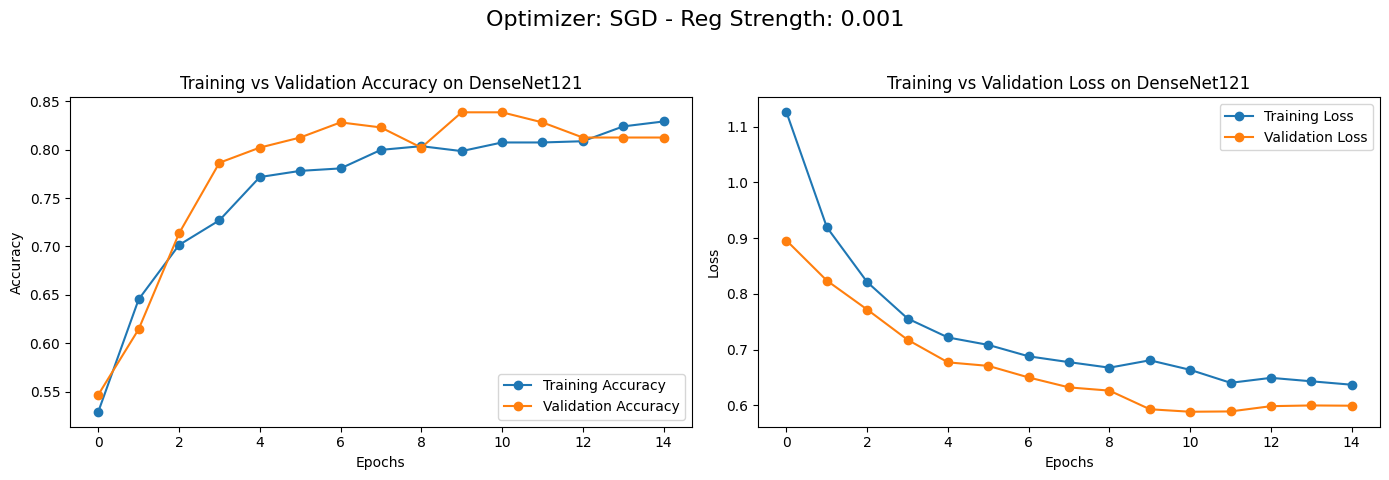

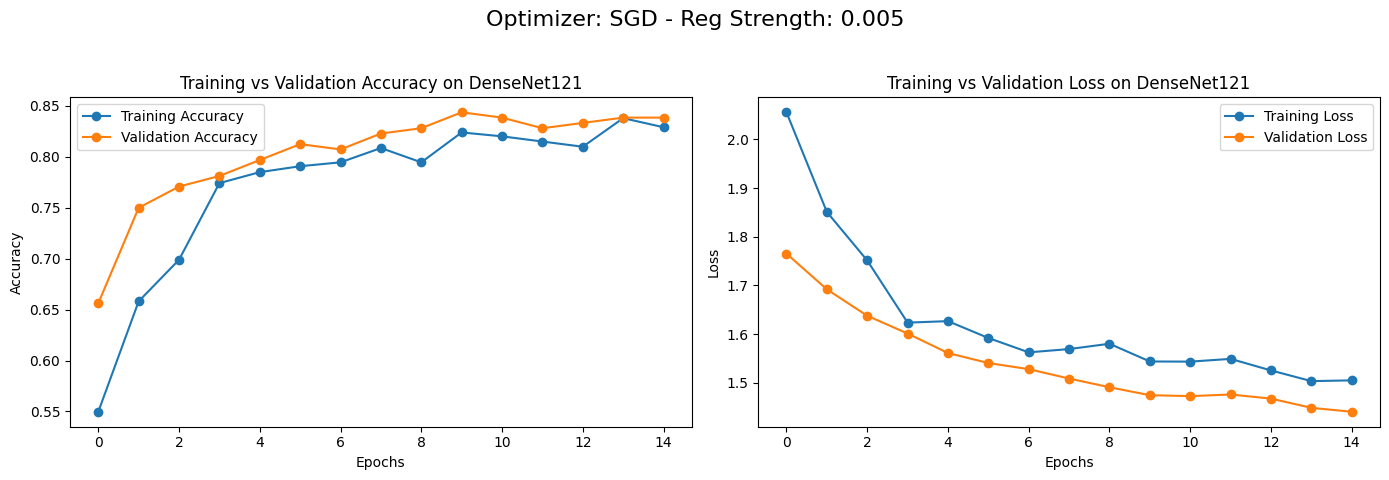

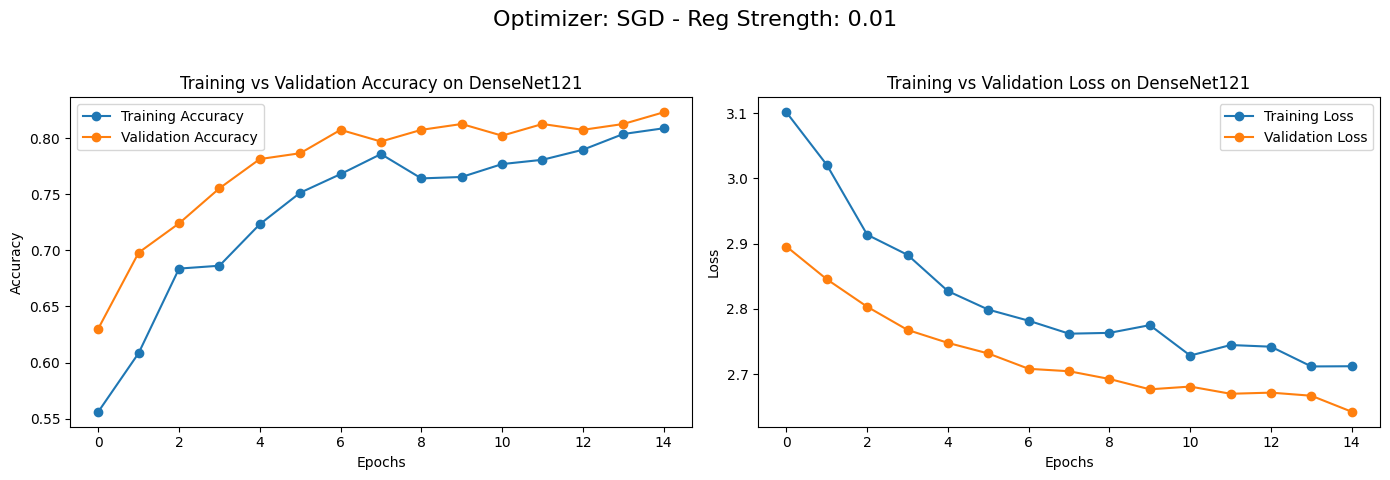

In [36]:
def plot_results_by_optimizer(optimizers, results):
    for optimizer in optimizers:
        optimizer_results = [r for r in results if r['optimizer'] == optimizer]
        for result in optimizer_results:
            fig, axes = plt.subplots(1, 2, figsize=(14, 5))
            fig.suptitle(f'Optimizer: {optimizer} - Reg Strength: {result["reg_strength"]}', fontsize=16)
            
            axes[0].plot(result['history']['accuracy'], label='Training Accuracy', marker='o')
            axes[0].plot(result['history']['val_accuracy'], label='Validation Accuracy', marker='o')
            axes[0].set_title('Training vs Validation Accuracy on DenseNet121')
            axes[0].set_xlabel('Epochs')
            axes[0].set_ylabel('Accuracy')
            axes[0].legend()
            
            axes[1].plot(result['history']['loss'], label='Training Loss', marker='o')
            axes[1].plot(result['history']['val_loss'], label='Validation Loss', marker='o')
            axes[1].set_title('Training vs Validation Loss on DenseNet121')
            axes[1].set_xlabel('Epochs')
            axes[1].set_ylabel('Loss')
            axes[1].legend()
            
            plt.tight_layout(rect=[0, 0.03, 1, 0.95])

            save_path = "Plots/Needs Respray/DenseNet121/"
            fig.savefig(f"{save_path}{optimizer}_{result['reg_strength']}.png")
            
            plt.show()

plot_results_by_optimizer(optimizers, results_densenet)

Observing Xception model performance on different parameters

In [26]:
input_shape_xception = (299, 299, 3)

training_data_xception = train_datagen.flow_from_directory(directory = img_dir_train, target_size = (299, 299), color_mode = 'rgb', batch_size = BATCH_SIZE, class_mode = 'binary', subset='training', shuffle = True, seed = 42)
validation_data_xception = train_datagen.flow_from_directory(directory = img_dir_train, target_size = (299, 299), color_mode = 'rgb', batch_size = BATCH_SIZE, class_mode = 'binary', subset='validation', shuffle = True, seed = 42)
testing_data_xception = test_datagen.flow_from_directory(directory = img_dir_test, target_size = (299, 299), color_mode = 'rgb', class_mode = 'binary', shuffle = False, seed = 42)

n_steps = training_data_xception.samples // BATCH_SIZE
n_val_steps = validation_data_xception.samples // BATCH_SIZE

Found 816 images belonging to 2 classes.
Found 204 images belonging to 2 classes.
Found 8 images belonging to 2 classes.


In [27]:
#DenseNet
def create_model_xception(input_shape, optimizer, lr, reg_strength=0.3):
    if optimizer == 'SGD':
        opt = SGD(learning_rate=lr)
    elif optimizer == 'RMSprop':
        opt = Adam(learning_rate=lr)
    elif optimizer == 'Adam':
        opt = RMSprop(learning_rate=lr)
    
    conv_base = Xception(include_top=False,
                      weights='imagenet',
                      input_shape=input_shape)
    
    for layer in conv_base.layers:
        layer.trainable = False
        
    top_model = conv_base.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(128, activation='relu', kernel_regularizer=l2(reg_strength))(top_model)
    top_model = BatchNormalization()(top_model)
    top_model = Dropout(0.5)(top_model)
    output_layer = Dense(1, activation='sigmoid')(top_model)
    
    model = Model(inputs=conv_base.input, outputs=output_layer)
    
    model.compile(optimizer=opt,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [28]:
results_xception = []

for reg_strength in regularization_strengths:
    for optimizer in optimizers:
        print(f"Training with {optimizer}, reg_strength={reg_strength}")
        model_xception = create_model_xception(input_shape_xception, optimizer, learning_rate, reg_strength=reg_strength)
        lr_scheduler = step_decay_schedule(learning_rate, decay_factor, step_size)
        history_xception = model_xception.fit(training_data_xception,
                            validation_data=validation_data_xception,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            epochs=n_epochs,
                            callbacks=[lr_scheduler],
                            verbose=1)
        results_xception.append({'optimizer': optimizer,
                        'reg_strength': reg_strength,
                        'history': history_xception.history})

Training with Adam, reg_strength=0.0001
83683744/83683744 [==============================] - 13s 0us/step
Epoch 1/15
25/25 [==============================] - 19s 646ms/step - loss: 0.5017 - accuracy: 0.7844 - val_loss: 0.4422 - val_accuracy: 0.8229 - lr: 0.0010
Epoch 2/15
25/25 [==============================] - 15s 610ms/step - loss: 0.2196 - accuracy: 0.9209 - val_loss: 0.3729 - val_accuracy: 0.8802 - lr: 0.0010
Epoch 3/15
25/25 [==============================] - 15s 612ms/step - loss: 0.1910 - accuracy: 0.9298 - val_loss: 0.3005 - val_accuracy: 0.9010 - lr: 0.0010
Epoch 4/15
25/25 [==============================] - 15s 614ms/step - loss: 0.1336 - accuracy: 0.9579 - val_loss: 0.2641 - val_accuracy: 0.9271 - lr: 0.0010
Epoch 5/15
25/25 [==============================] - 15s 615ms/step - loss: 0.1158 - accuracy: 0.9656 - val_loss: 0.2238 - val_accuracy: 0.9427 - lr: 0.0010
Epoch 6/15
25/25 [==============================] - 15s 630ms/step - loss: 0.0857 - accuracy: 0.9719 - val_loss: 0

In [1]:
def plot_results_by_optimizer(optimizers, results):
    for optimizer in optimizers:
        optimizer_results = [r for r in results if r['optimizer'] == optimizer]
        for result in optimizer_results:
            fig, axes = plt.subplots(1, 2, figsize=(14, 5))
            fig.suptitle(f'Optimizer: {optimizer} - Reg Strength: {result["reg_strength"]}', fontsize=16)
            
            # Plot Training and Validation Accuracy
            axes[0].plot(result['history']['accuracy'], label='Training Accuracy', marker='o')
            axes[0].plot(result['history']['val_accuracy'], label='Validation Accuracy', marker='o')
            axes[0].set_title('Training vs Validation Accuracy on Xception')
            axes[0].set_xlabel('Epochs')
            axes[0].set_ylabel('Accuracy')
            axes[0].legend()

            # Annotate the last points for accuracy
            last_epoch = len(result['history']['accuracy']) - 1
            last_train_acc = result['history']['accuracy'][-1]
            last_val_acc = result['history']['val_accuracy'][-1]
            axes[0].text(last_epoch, last_train_acc, f'{last_train_acc:.2f}', color='blue', ha='right')
            axes[0].text(last_epoch, last_val_acc, f'{last_val_acc:.2f}', color='orange', ha='right')
            
            # Plot Training and Validation Loss
            axes[1].plot(result['history']['loss'], label='Training Loss', marker='o')
            axes[1].plot(result['history']['val_loss'], label='Validation Loss', marker='o')
            axes[1].set_title('Training vs Validation Loss on Xception')
            axes[1].set_xlabel('Epochs')
            axes[1].set_ylabel('Loss')
            axes[1].legend()

            # Annotate the last points for loss
            last_train_loss = result['history']['loss'][-1]
            last_val_loss = result['history']['val_loss'][-1]
            axes[1].text(last_epoch, last_train_loss, f'{last_train_loss:.2f}', color='blue', ha='right')
            axes[1].text(last_epoch, last_val_loss, f'{last_val_loss:.2f}', color='orange', ha='right')
            
            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            
            # Save the figure
            save_path = "Plots/Needs Respray/Xception/"
            fig.savefig(f"{save_path}{optimizer}_{result['reg_strength']}.png")
            
            plt.show()

plot_results_by_optimizer(optimizers, results_xception)

NameError: name 'optimizers' is not defined

Observing EfficientNetB2 model performance on different parameters

In [30]:
input_shape_enet= (260, 260, 3)

training_data_enet = train_datagen.flow_from_directory(directory = img_dir_train, target_size = (260, 260), color_mode = 'rgb', batch_size = BATCH_SIZE, class_mode = 'binary', subset='training', shuffle = True, seed = 42)
validation_data_enet = train_datagen.flow_from_directory(directory = img_dir_train, target_size = (260, 260), color_mode = 'rgb', batch_size = BATCH_SIZE, class_mode = 'binary', subset='validation', shuffle = True, seed = 42)
testing_data_enet = test_datagen.flow_from_directory(directory = img_dir_test, target_size = (260, 260), color_mode = 'rgb', class_mode = 'binary', shuffle = False, seed = 42)

n_steps = training_data_enet.samples // BATCH_SIZE
n_val_steps = validation_data_enet.samples // BATCH_SIZE

Found 816 images belonging to 2 classes.
Found 204 images belonging to 2 classes.
Found 8 images belonging to 2 classes.


In [31]:
#DenseNet
def create_model_enet(input_shape, optimizer, lr, reg_strength=0.3):
    if optimizer == 'SGD':
        opt = SGD(learning_rate=lr)
    elif optimizer == 'RMSprop':
        opt = Adam(learning_rate=lr)
    elif optimizer == 'Adam':
        opt = RMSprop(learning_rate=lr)
    
    conv_base = EfficientNetB2(include_top=False,
                      weights='imagenet',
                      input_shape=input_shape)
    
    for layer in conv_base.layers:
        layer.trainable = False
        
    top_model = conv_base.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(128, activation='relu', kernel_regularizer=l2(reg_strength))(top_model)
    top_model = BatchNormalization()(top_model)
    top_model = Dropout(0.5)(top_model)
    output_layer = Dense(1, activation='sigmoid')(top_model)
    
    model = Model(inputs=conv_base.input, outputs=output_layer)
    
    model.compile(optimizer=opt,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [32]:
results_enet = []

for reg_strength in regularization_strengths:
    for optimizer in optimizers:
        print(f"Training with {optimizer}, reg_strength={reg_strength}")
        model_enet = create_model_enet(input_shape_enet, optimizer, learning_rate, reg_strength=reg_strength)
        lr_scheduler = step_decay_schedule(learning_rate, decay_factor, step_size)
        history_enet = model_enet.fit(training_data_enet,
                            validation_data=validation_data_enet,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            epochs=n_epochs,
                            callbacks=[lr_scheduler],
                            verbose=1)
        results_enet.append({'optimizer': optimizer,
                        'reg_strength': reg_strength,
                        'history': history_enet.history})

Training with Adam, reg_strength=0.0001
31790344/31790344 [==============================] - 4s 0us/step
Epoch 1/15
25/25 [==============================] - 23s 693ms/step - loss: 0.8885 - accuracy: 0.4974 - val_loss: 0.7279 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/15
25/25 [==============================] - 15s 621ms/step - loss: 0.7991 - accuracy: 0.5051 - val_loss: 0.7226 - val_accuracy: 0.4948 - lr: 0.0010
Epoch 3/15
25/25 [==============================] - 15s 610ms/step - loss: 0.8080 - accuracy: 0.4987 - val_loss: 0.7539 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/15
25/25 [==============================] - 15s 598ms/step - loss: 0.7602 - accuracy: 0.5242 - val_loss: 0.7210 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 5/15
25/25 [==============================] - 15s 608ms/step - loss: 0.7863 - accuracy: 0.4925 - val_loss: 0.7114 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 6/15
25/25 [==============================] - 15s 599ms/step - loss: 0.7533 - accuracy: 0.4949 - val_loss: 0.

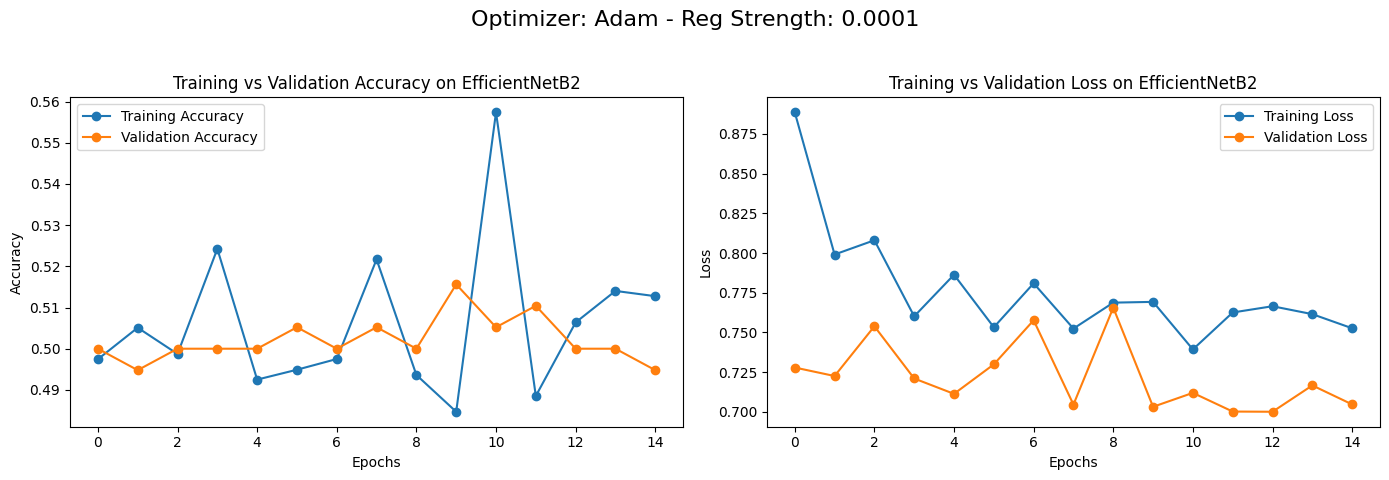

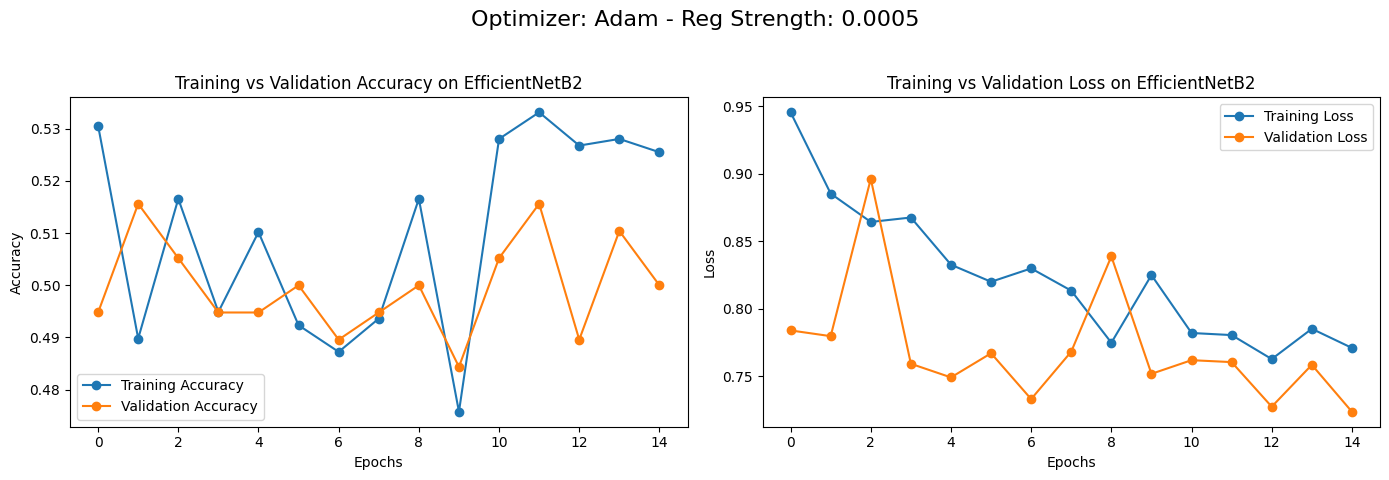

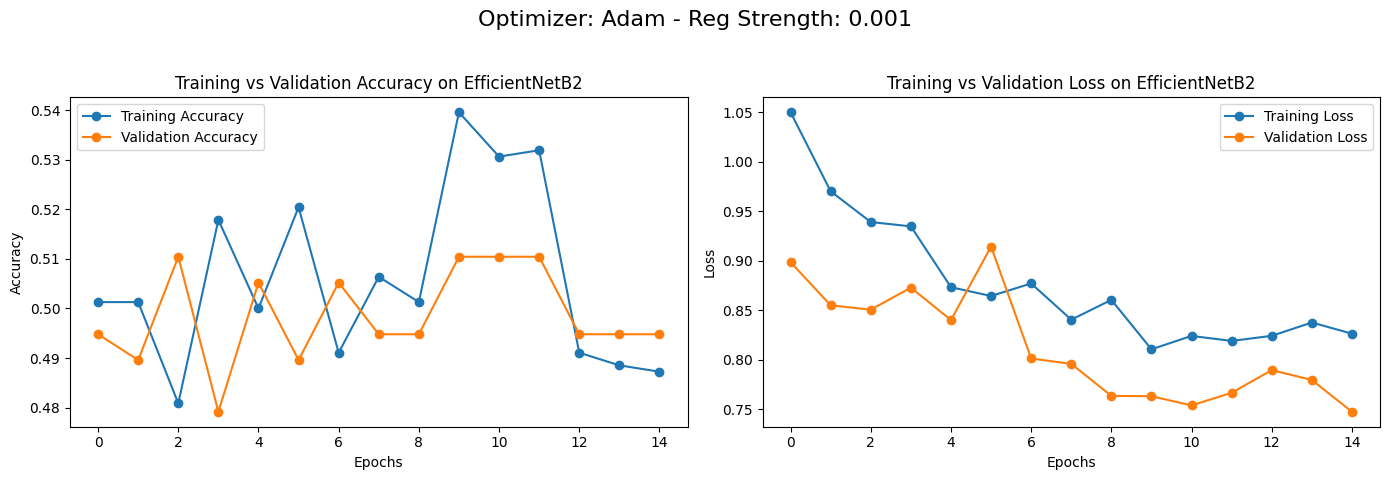

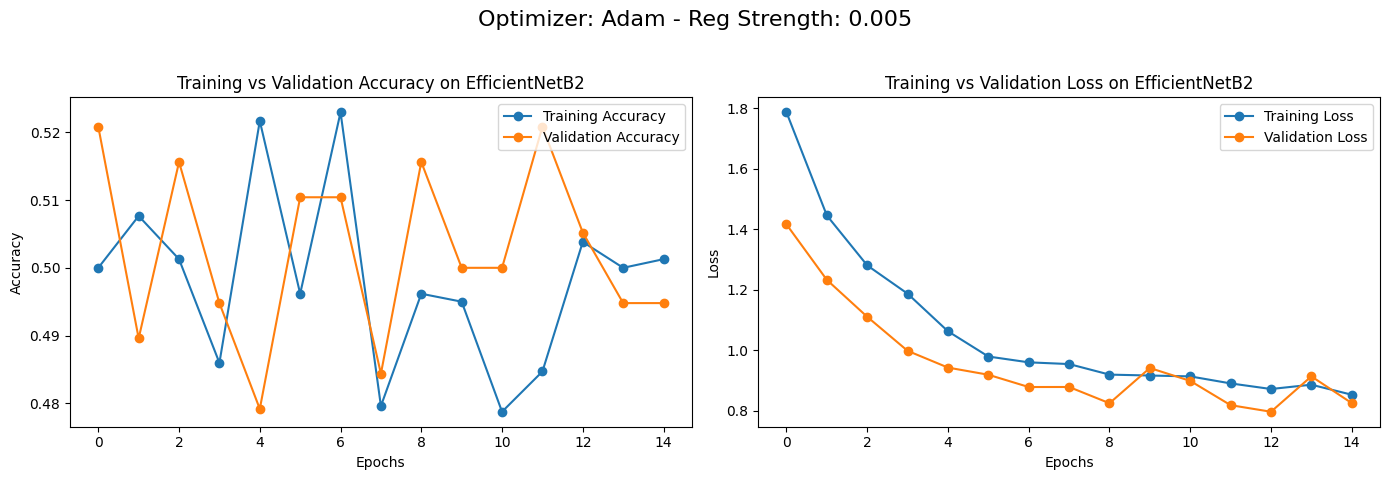

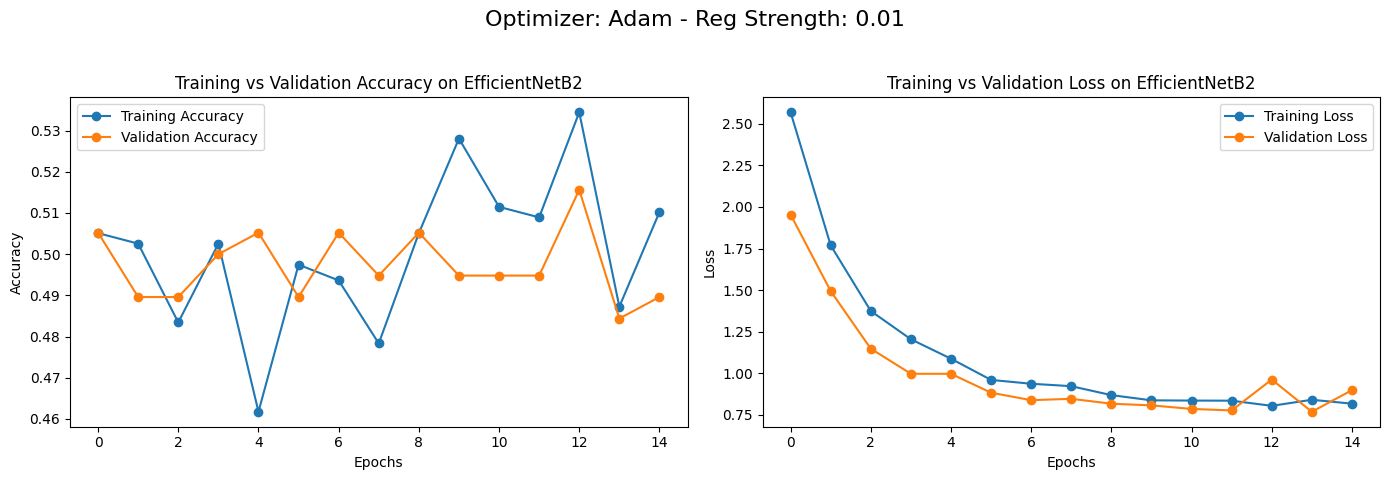

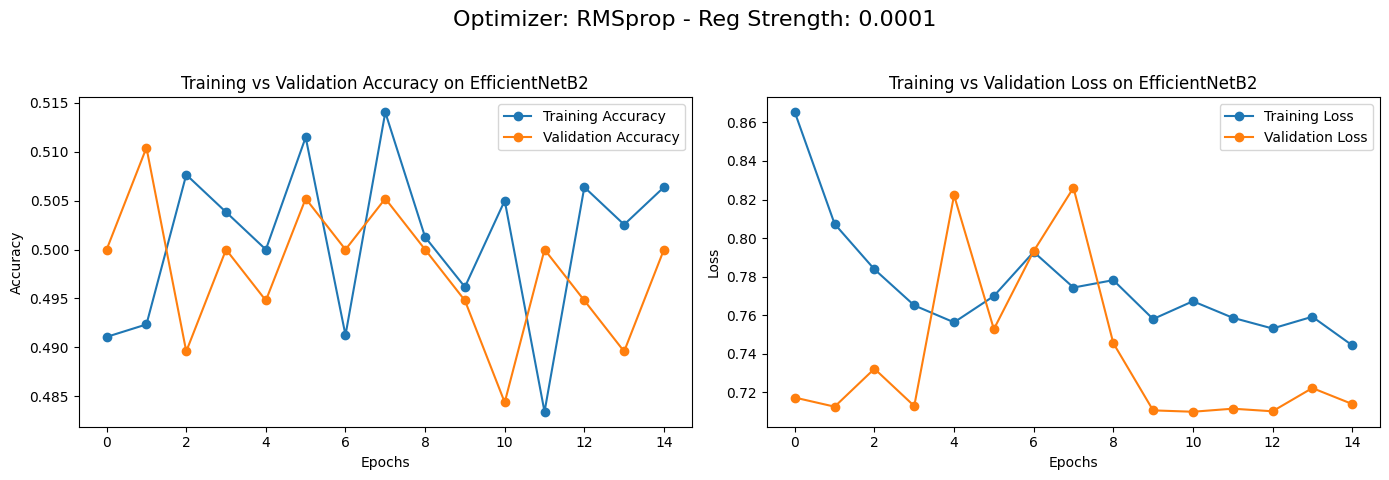

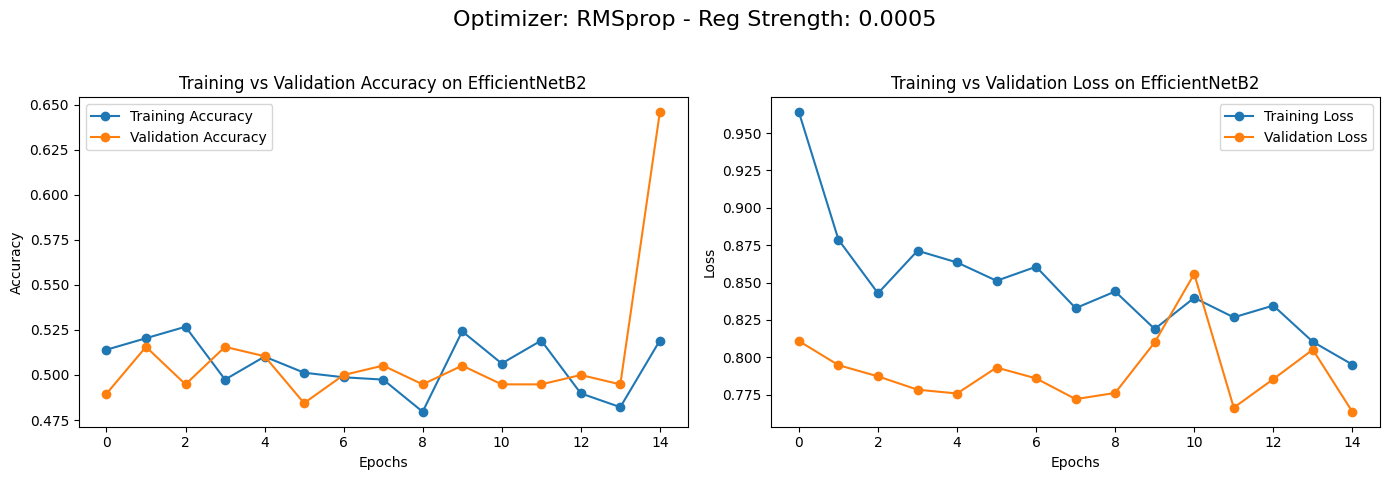

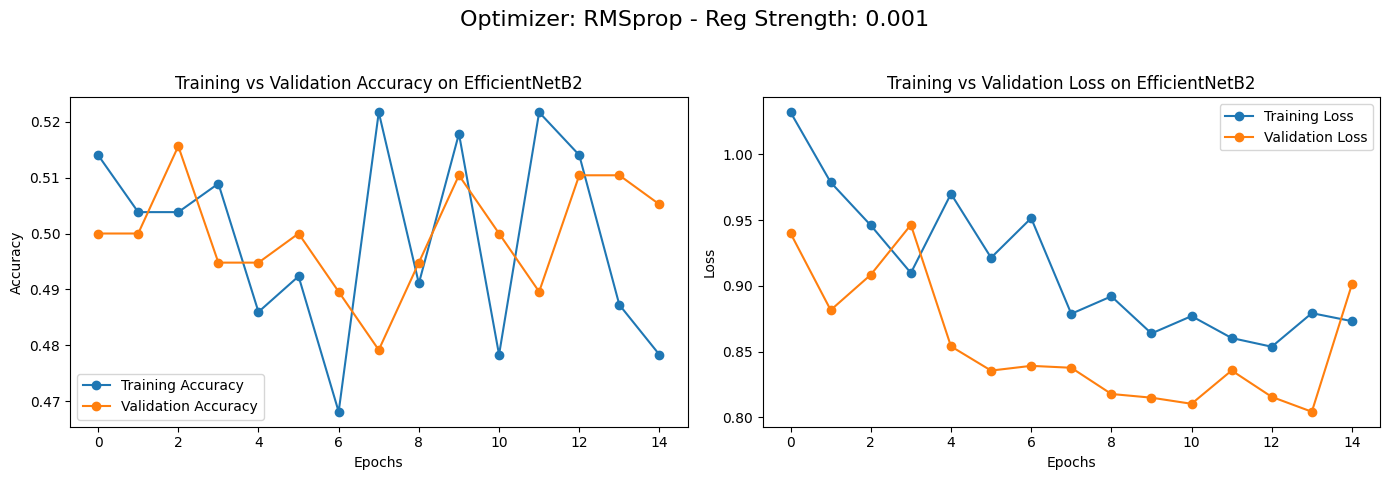

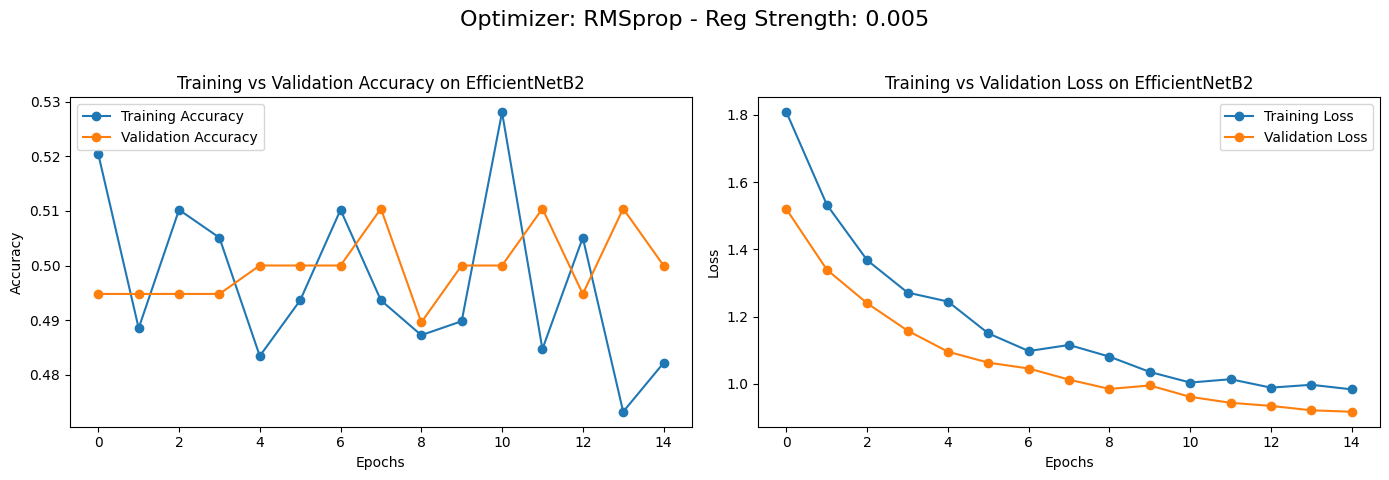

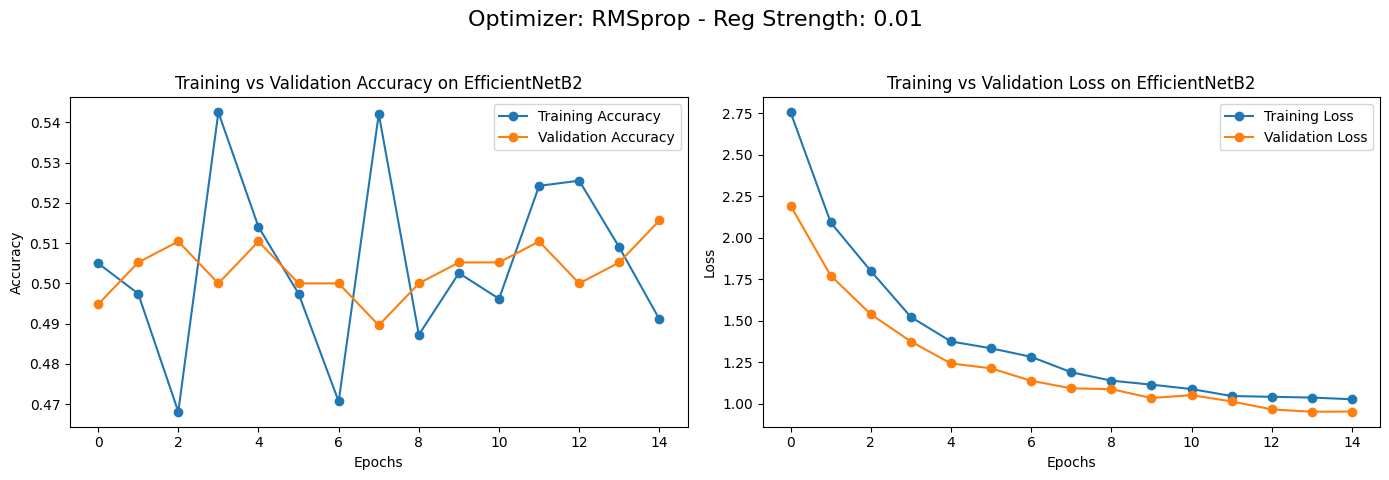

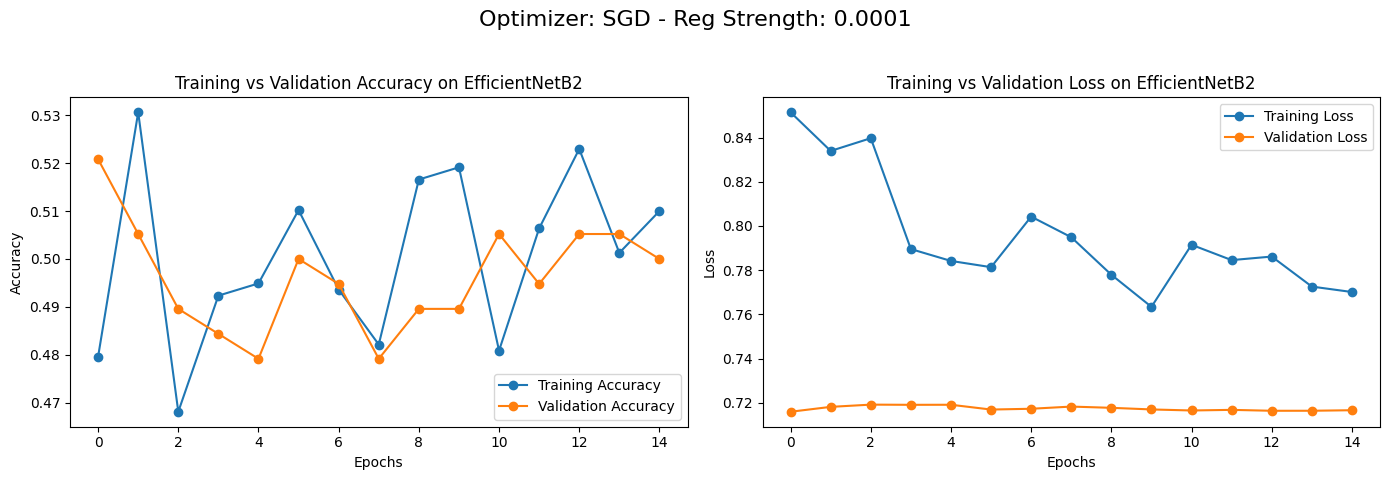

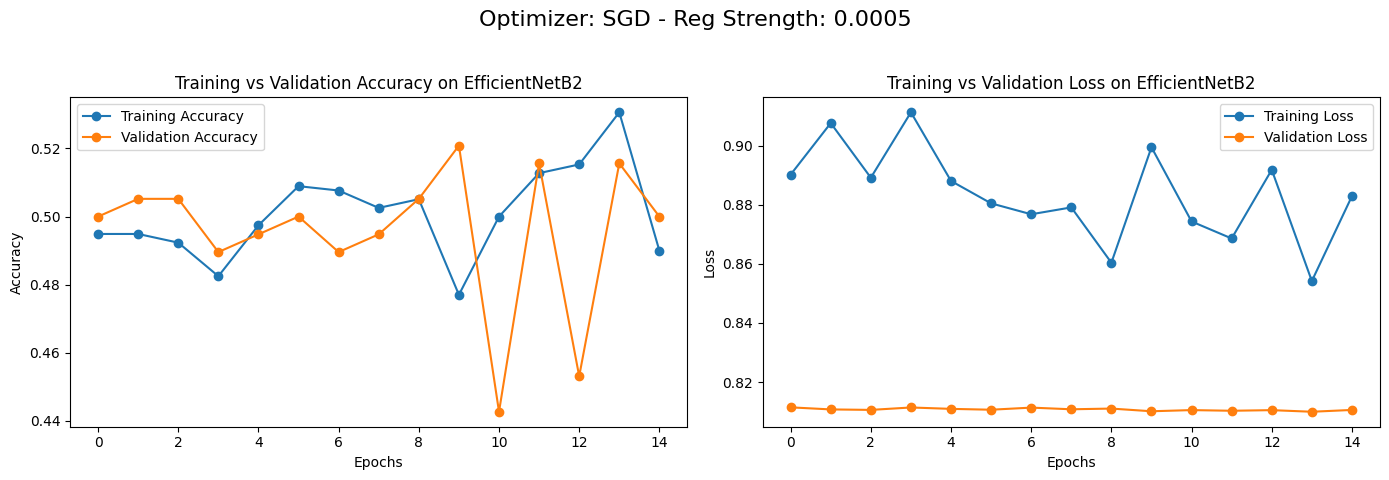

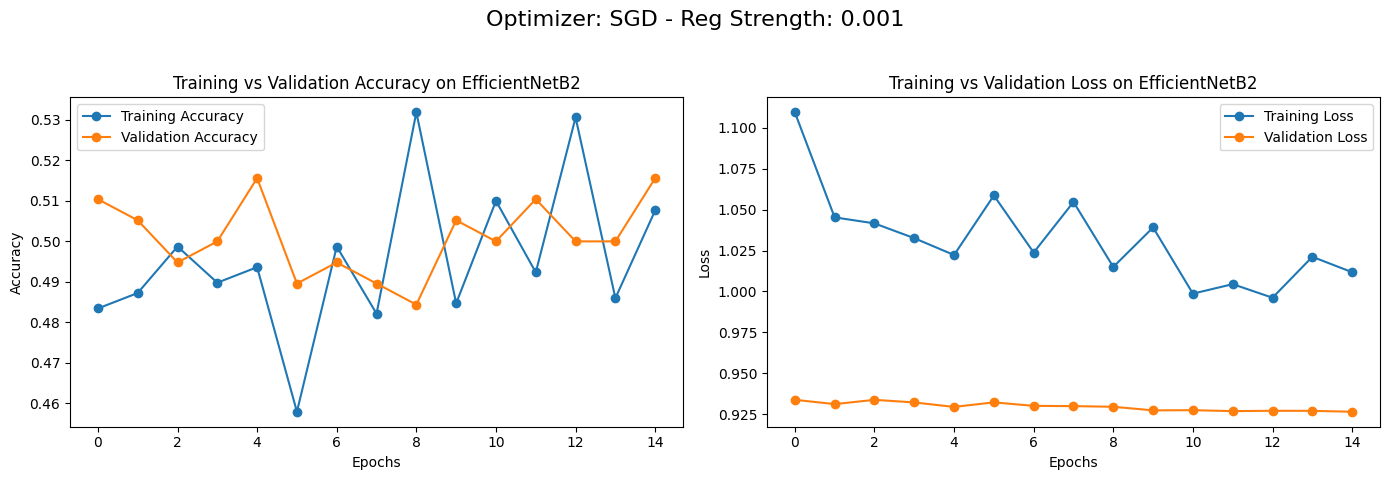

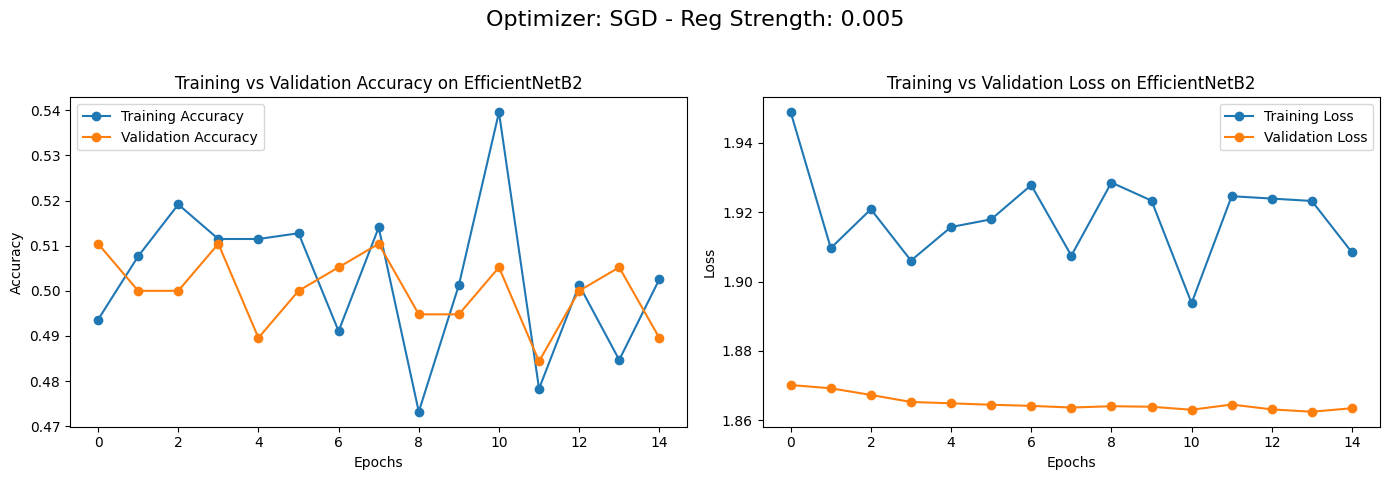

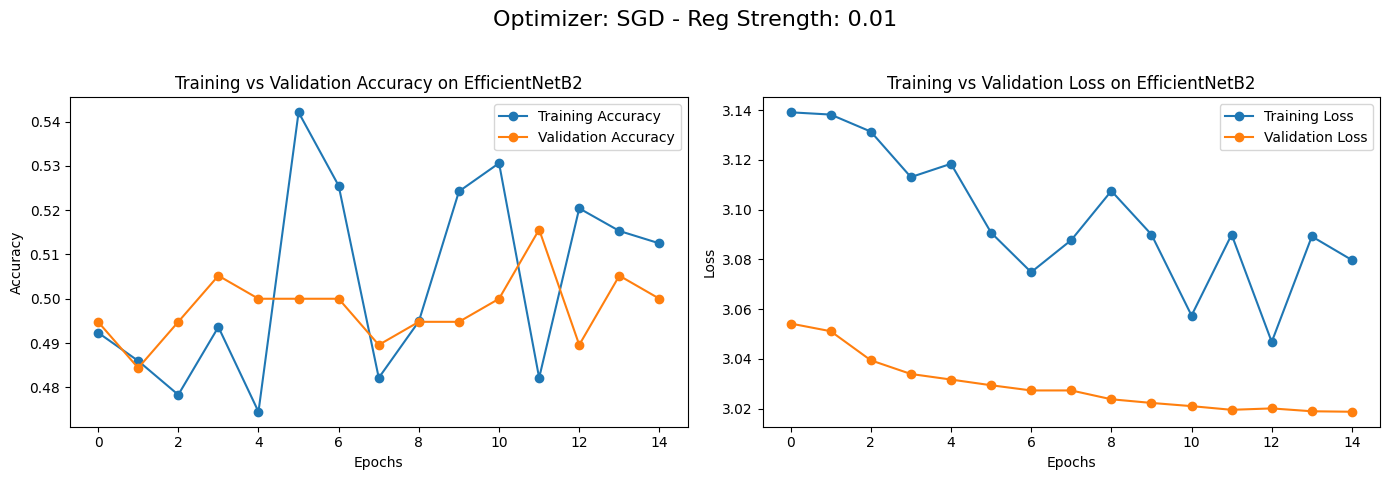

In [39]:
def plot_results_by_optimizer(optimizers, results):
    for optimizer in optimizers:
        optimizer_results = [r for r in results if r['optimizer'] == optimizer]
        for result in optimizer_results:
            fig, axes = plt.subplots(1, 2, figsize=(14, 5))
            fig.suptitle(f'Optimizer: {optimizer} - Reg Strength: {result["reg_strength"]}', fontsize=16)
            
            axes[0].plot(result['history']['accuracy'], label='Training Accuracy', marker='o')
            axes[0].plot(result['history']['val_accuracy'], label='Validation Accuracy', marker='o')
            axes[0].set_title('Training vs Validation Accuracy on EfficientNetB2')
            axes[0].set_xlabel('Epochs')
            axes[0].set_ylabel('Accuracy')
            axes[0].legend()
            
            axes[1].plot(result['history']['loss'], label='Training Loss', marker='o')
            axes[1].plot(result['history']['val_loss'], label='Validation Loss', marker='o')
            axes[1].set_title('Training vs Validation Loss on EfficientNetB2')
            axes[1].set_xlabel('Epochs')
            axes[1].set_ylabel('Loss')
            axes[1].legend()
            
            plt.tight_layout(rect=[0, 0.03, 1, 0.95])

            save_path = "Plots/Needs Respray/EfficientNetB2/"
            fig.savefig(f"{save_path}{optimizer}_{result['reg_strength']}.png")
            
            plt.show()

plot_results_by_optimizer(optimizers, results_enet)

When evaluating machine learning models using training and validation graphs, there are specific patterns and indicators that can suggest whether a model is overfitting:

 * Overfitting is indicated by a significant and increasing gap between training and validation accuracy. The training accuracy continues to improve while the validation accuracy stagnates or declines.
 * A model that generalizes well will show a validation loss that decreases alongside the training loss. Signs of overfitting include a validation loss that begins to increase or fluctuates widely while the training loss continues to decrease.
 * Some degree of fluctuation in validation metrics is normal, but erratic or extreme changes can indicate issues. If the validation loss or accuracy plateaus early while training metrics continue to improve, this could be a sign that the model is no longer learning generalizable patterns.

Based on the graphs, the following configurations did not show significant signs of overfitting and displayed characteristics of good generalization:

 * VGG16 Model with SGD, Reg Strength: 0.0005
 * Inception-v3 Model with SGD, Reg Strength: 0.0005
 * Inception-v3 Model with SGD, Reg Strength: 0.005
 * DenseNet121 Model with SGD, Reg Strength: 0.0001
 * DenseNet121 Model with SGD, Reg Strength: 0.001
 * DenseNet121 Model with SGD, Reg Strength: 0.0005
 * Xception Model with SGD, Reg Strength: 0.01
 * Xception Model with SGD, Reg Strength: 0.0005